# Model implementation for a single subject:

In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import matplotlib.pyplot as plt

## Importing custom functions from different folder:

In [61]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    from utils_data import load_data, data_clustering, plot_data, cleaning_data, linear_transf
    
    #from utils_data import experimental_velocity, plot_velocity, saving_processed_data
    from utils_data import load_processed_data, saving_processed_data, processing_data, experimental_velocity, plot_velocity
    from utils_model import numericalSimulation, ComputeFunctional, ComputeVel, generate_trajectory, plot_multiple_trajectories_combined
    from utils_model import plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories, fitParamaters, compute_mse_between_averages
    
    from utils_model_multiple import plotting_params, box_plot_params, plot_gaussian_distributions_theo 
    
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Data exploration

The data considered on this notebook contains the trajectories for a single subject, for all the possible configurations, and for the different possible targets.

## Reproducing results

We can reproduce our results in this Notebook by setting the initial parameters as well as on the `main.py` file. 

Set the following parameters according to the study you wish to conduct: 
- `processing` when set to `True` it conducts the whole processing process from the raw data. This includes: 
    - `data_clustering`: 
        - Classifying the data in 4 clusters, depending on the target they cross using a RNN classifying algorithm. 
    - `cleaning_data`: 
        - Cleaning the trajectories which do not cross the target and truncating the ones which do cross it. Also storing the optimal time in which they reach the target, $T^*$, stored in `idxrule`
    - `linear_transf`:
        - Rotating the needed trajectories and scaling them in order to get normalized data
        - Computing the mean velocity and the velocity profiles for each trajectory

- `fitting` when set to `True` the fitting of the parameters is conducted with the already processed data. This includes: 
    - `fitParamaters`: 
        - Sequential approach: 
            1. Optimal movement duration: Generate the optimal trajectory by optimizing the Functional in terms of the time T 
            2. Optimal controller: generate the optimal trajectory with the optimal time duration by minimizing the functional in terms of the biomechanical parameters $(\alpha, \gamma, \varepsilon)$. 
            3. Stochastic optimization: generate the optimal trajectory with optimal time duration and biomechanical parameters by optimizing the Kolmogorov Sirnov estimate in terms of the sigma 
        - Saving the obtained parameters

- `plotting` when set to `True` all the trajectory plots and prints are explicitly shown on this Notebook
- `saving` when set to `True` all the plots and data processed is saved. 

In [3]:
processing = False
fitting = False
plotting = False
saving = False

# Loading processed data: 

In [4]:
if not processing:
    # Loading the processed data: 
    print('Loading processed data...')
    n_clusters = 4
    dfx = [[] for _ in range(n_clusters)]
    dfy = [[] for _ in range(n_clusters)]
    for cluster in range(n_clusters): 
        dfx[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfx.csv'.format(cluster))
        dfy[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfy.csv'.format(cluster))
    results = load_processed_data(folder_path='processed_data', file_name='results.csv') 

Loading processed data...


In [5]:
results

cluster                          rectx                      recty   
0        0      [ 9.5  10.75 11.5  12.75]          [6.6 7.6 3.1 4.1]  \
1        1  [-12.   -13.25 -10.   -11.25]  [-3.25 -4.25 -6.75 -7.75]   
2        2      [11.5  12.75  9.5  10.75]  [ 1.75  0.75 -1.75 -2.75]   
3        3  [ -9.5  -10.75 -11.5  -12.75]      [ 3.   4.  -0.5  0.5]   

                                             idxrule    mean_T   max_vel  
0  [1814, 1404, 1654, 1791, 1291, 1672, 1632, 171...  1.319448  0.005534  
1  [1698, 1554, 1868, 1708, 1313, 1274, 1455, 141...  1.295982  0.005831  
2  [1487, 1293, 1305, 1366, 1198, 1132, 1353, 128...  1.251862  0.004535  
3  [2042, 1197, 1369, 1063, 1131, 1495, 1305, 112...  1.304000  0.004591

# Processing the data

In [6]:
if processing: 
        print('Loading and processing data...')
        results, dfx, dfy = processing_data()

# Parameter fitting: 

## Computing trajectories for optimized velocity for each cluster

In [7]:
if fitting: 
    print('Fitting paramaters for the optimized trajectory...')   
    new_params, opt_sigma = fitParamaters(results, dfx, dfy, plotting = plotting, saving = saving)  
    combined_params = [] 
    for cluster in range(n_clusters):
        if plotting: 
            plot_multiple_trajectories(dfx[cluster], dfy[cluster], cluster = cluster, 
                               new_params = new_params[cluster], opt_Sigma = opt_sigma[cluster], 
                               pic_name = 'Simulated and experimental data', saving_plot = saving)
        combined_params.append(np.hstack((new_params[cluster].x, opt_sigma[cluster].x)))
    parameters_fitted = pd.DataFrame(combined_params)
    params_fitted = np.array(combined_params)
    saving_processed_data(parameters_fitted, folder_name = 'fitted_data', file_name = 'fitted_parameters_2')
    if plotting: 
        box_plot_params(params_fitted, pic_name = 'parameters_boxplot_4', saving_plot= saving)

else: 
    parameters_fitted = load_processed_data(folder_path = 'fitted_data', file_name = 'fitted_parameters.csv')
    params_fitted = np.array(parameters_fitted)

## Simulating trajectories: 

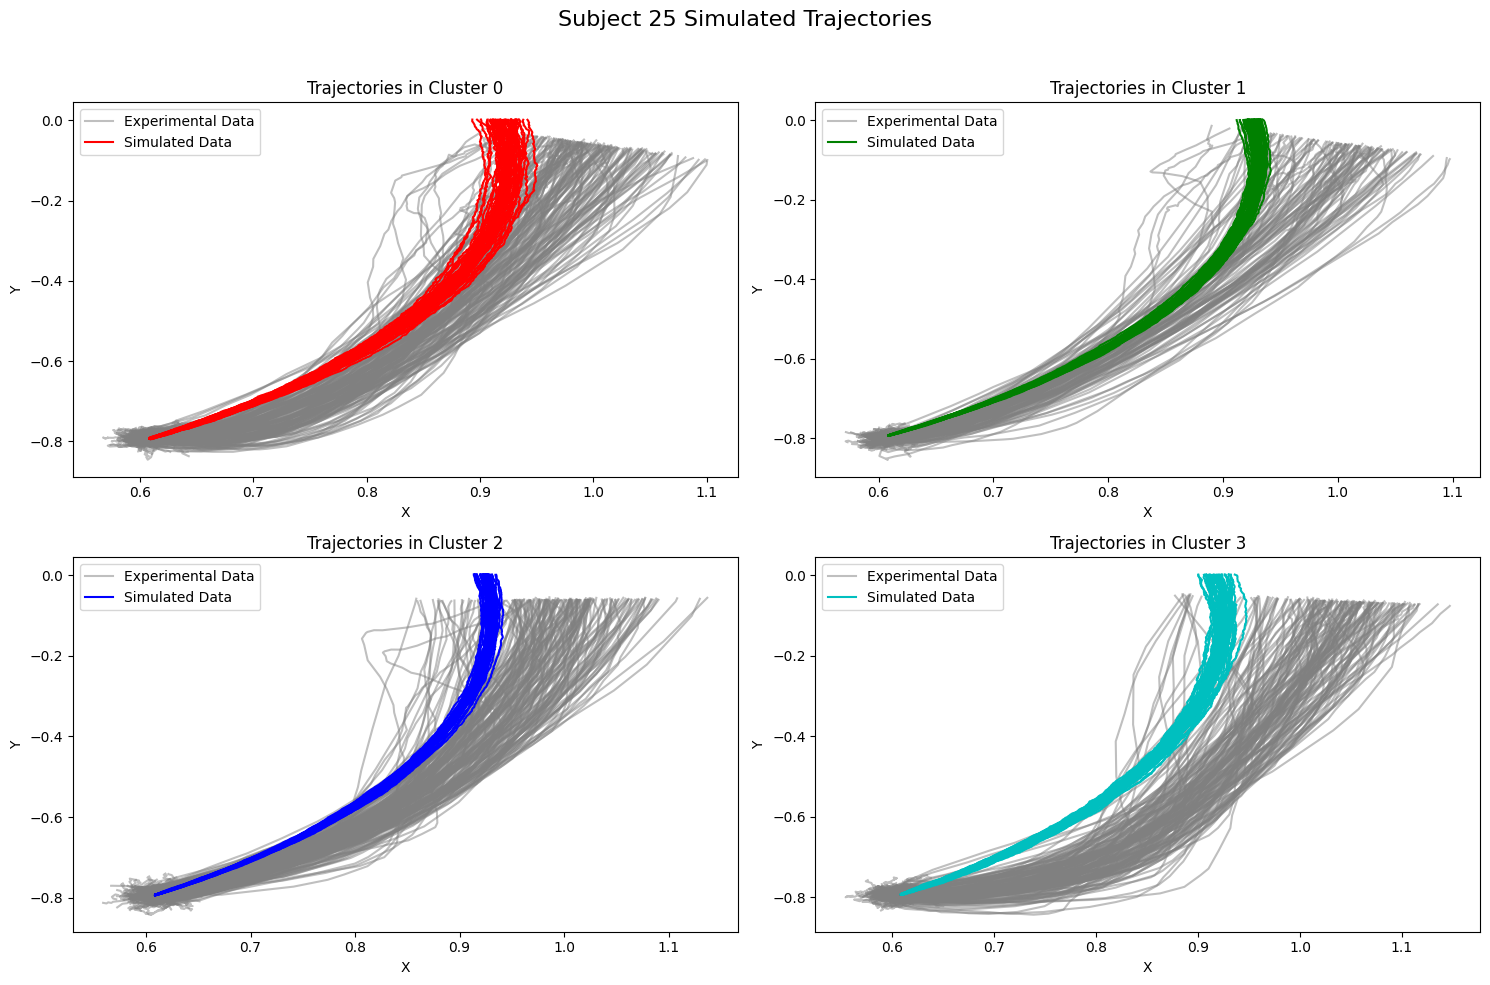

In [35]:
plot_multiple_trajectories(dfx, dfy, 
                           n_clusters = 4, new_params = params_fitted[:, :-1], 
                           opt_Sigma = params_fitted[:,-1], 
                           pic_name = 'Trajectories_simulated_25', pic_folder = 'project_plots',
                           saving_plot = True)

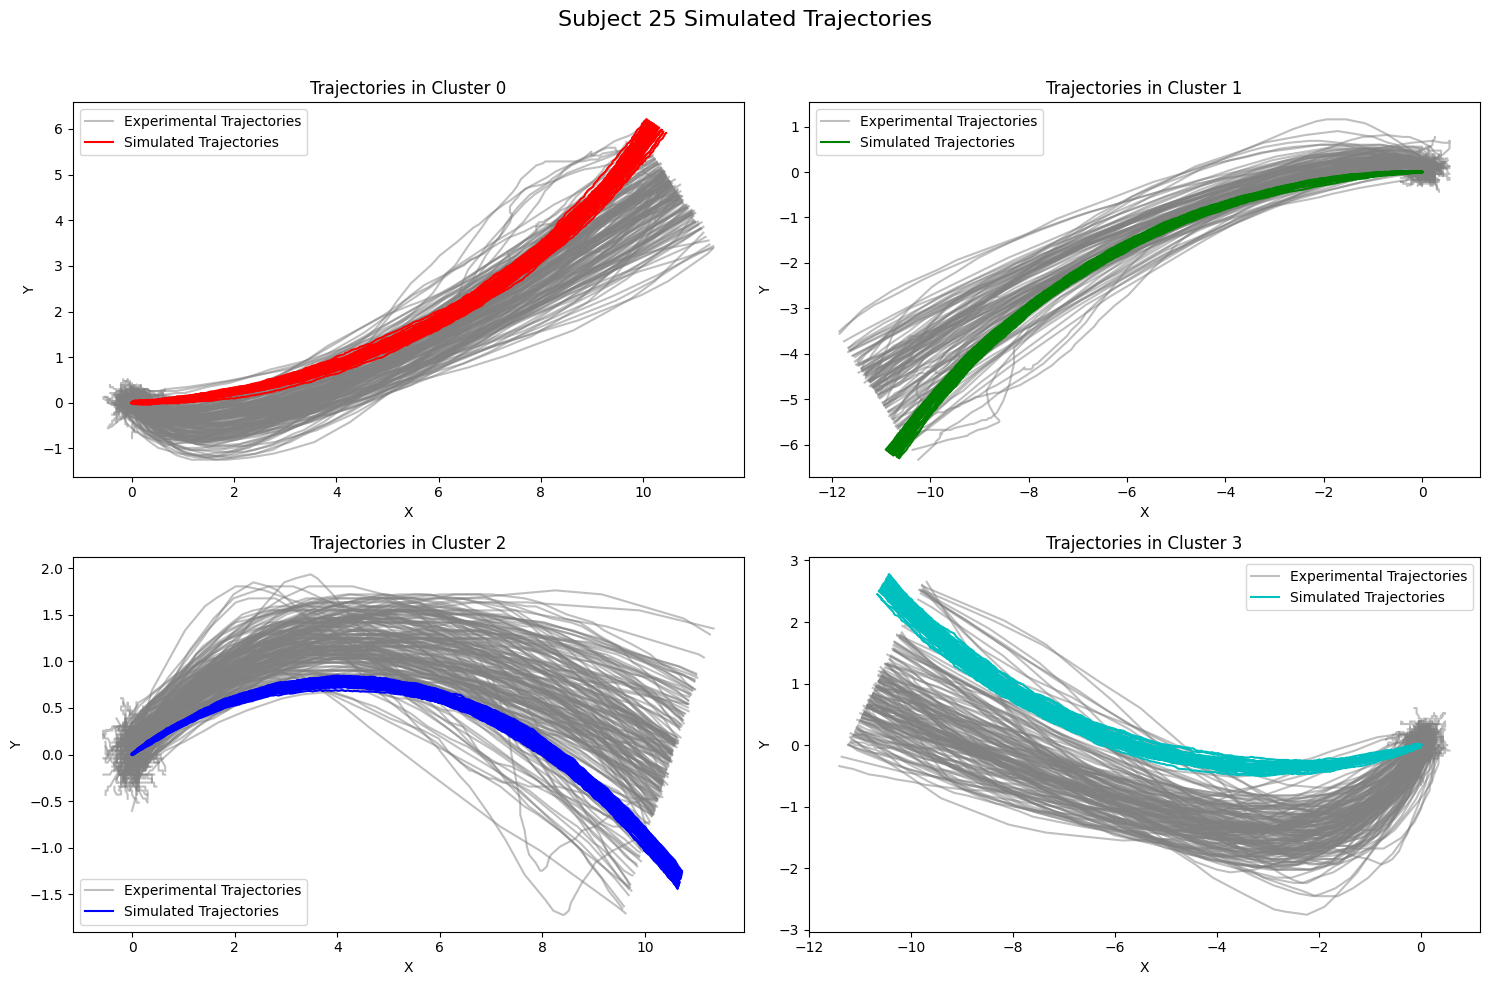

In [81]:
plot_multiple_trajectories_(dfx, dfy, 
                           n_clusters = 4, new_params = params_fitted[:, :-1], 
                           opt_Sigma = params_fitted[:,-1], 
                           results = results, 
                           pic_name = 'Trajectories_simulated_25_inverted', pic_folder = 'project_plots',
                           saving_plot = True, inverse = True)

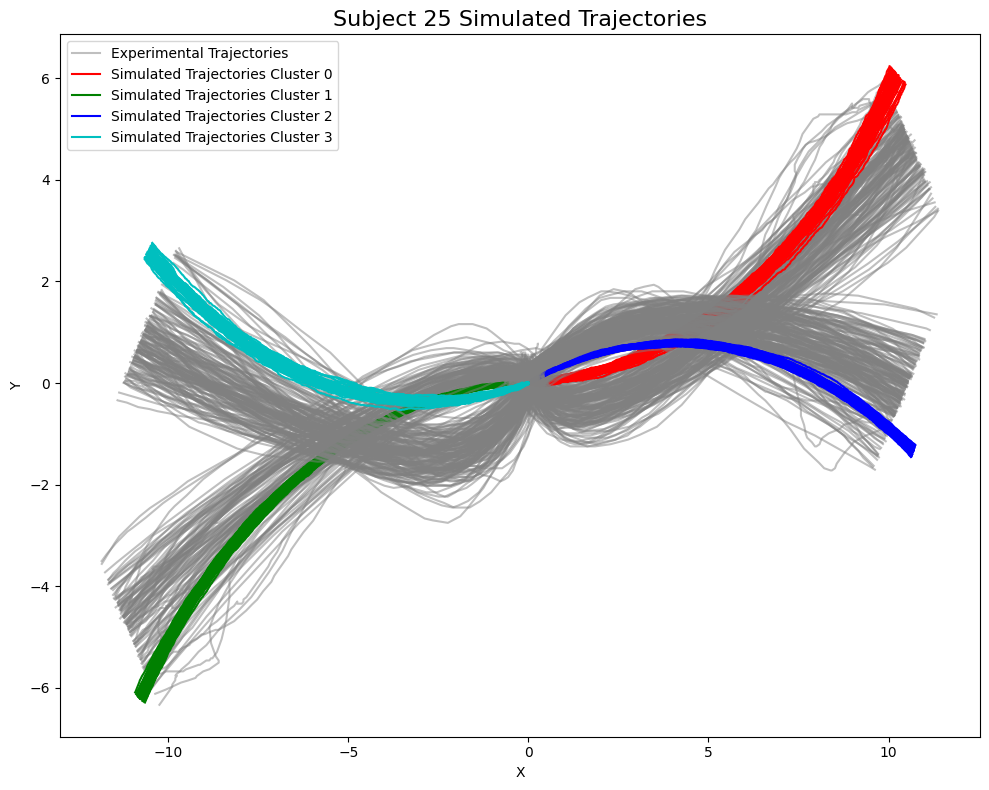

In [86]:
plot_multiple_trajectories_combined(dfx, dfy, 
                           n_clusters = 4, new_params = params_fitted[:, :-1], 
                           opt_Sigma = params_fitted[:,-1], 
                           results = results, 
                           pic_name = 'Trajectories_simulated_25_inverted_combined', pic_folder = 'project_plots',
                           saving_plot = True, inverse = True)

### Accuracy metrics

In [83]:
def pad_trajectories(trajectories):
    max_length = max(len(t) for t in trajectories)
    padded_trajectories = np.array([np.pad(t, (0, max_length - len(t)), 'constant', constant_values=np.nan) for t in trajectories])
    return padded_trajectories

def pad_or_truncate_trajectories(trajectories, target_length):
    return np.array([np.pad(t, (0, max(0, target_length - len(t))), 'constant', constant_values=np.nan)[:target_length] for t in trajectories])


def plot_multiple_trajectories_combined_(dfx: pd.DataFrame, dfy: pd.DataFrame,
                                         n_clusters: int, new_params: np.ndarray, opt_Sigma: np.float64,
                                         results: pd.DataFrame,
                                         parameters2=(3.7, -0.15679707, 0.97252444, 0.54660283, -6.75775885, -0.06253371),
                                         subject=25,
                                         n=50, timestep=1/500,
                                         pic_name='Trajectories_combined', pic_folder='project_plots',
                                         saving_plot=False,
                                         inverse=False, 
                                         metrics=True, 
                                         plotting_vel = True):

    if plotting_vel: 
        fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 16))
        ax2.set_title(f'Subject {subject} Simulated Valocity', fontsize=16)
        
    else: 
        fig, ax = plt.subplots(figsize=(10, 8))
        
    ax.set_title(f'Subject {subject} Simulated Trajectories', fontsize=16)
    colors = ['r', 'g', 'b', 'c']
    
    metrics_results = {}

    for cluster in range(n_clusters):

        rectx_list = results.rectx[cluster].replace(']', ' ')
        rectx_list = rectx_list.replace('[', ' ')
        rectx_list = rectx_list.split()
        rectx = np.array(rectx_list, dtype=float)

        recty_list = results.recty[cluster].replace(']', ' ')
        recty_list = recty_list.replace('[', ' ')
        recty_list = recty_list.split()
        recty = np.array(recty_list, dtype=float)

        # Plotting experimental data
        if inverse:
            dfx_, dfy_ = linear_transf(dfx[cluster], dfy[cluster], rectx, recty, inverse=True)
            for i in range(len(dfx[cluster])):
                ax.plot(dfx_.iloc[i], dfy_.iloc[i], color='gray', alpha=0.5, label='Experimental Trajectories' if i == 0 and cluster == 0 else "")
        else:
            for i in range(len(dfx[cluster])):
                ax.plot(dfx[cluster].iloc[i], dfy[cluster].iloc[i], color='gray', alpha=0.5, label='Experimental Trajectories' if i == 0 else "")

        # Plotting numerical simulation
        gamma, epsilon, alpha = new_params[cluster]
        sigma = opt_Sigma[cluster]

        simulated_x = []
        simulated_y = []
        t_ = []

        for i in range(n):
            x, y, v, w, ux, uy, T = numericalSimulation(x_0=(0, 0, 0, 0), p_T=1.0,
                                                        sigma=sigma, gamma=gamma, epsilon=epsilon, alpha=alpha,
                                                        u_0=parameters2[:2], l_0=parameters2[2:],
                                                        i_max=1000, dt=timestep,
                                                        Autoregr=False,
                                                        Arc=True, angle=math.pi*7/24, angle0=0, p=(.2, 0), r=.1)
            t_.append(T)
            if plotting_vel: 
                dfv=np.sqrt(np.square(v)+np.square(w))
                ax2.plot(dfv, color=colors[cluster], label=f'Simulated Velocity Cluster {cluster}' if i == 0 else "") 
                 
                #ax2.plot(v, w, color=colors[cluster], label=f'Simulated Velocity Cluster {cluster}' if i == 0 else "") 
                
            if inverse:
                x_, y_ = linear_transf(x, y, rectx, recty, inverse=True)
                simulated_x.append(x_)
                simulated_y.append(y_)
                ax.plot(x_, y_, color=colors[cluster], label=f'Simulated Trajectories Cluster {cluster}' if i == 0 else "")
            else:
                simulated_x.append(x)
                simulated_y.append(y)
                ax.plot(x, y, color=colors[cluster], label=f'Simulated Trajectories Cluster {cluster}' if i == 0 else "")
        
        if metrics:
            if cluster not in metrics_results:
                metrics_results[cluster] = {}
            # Padding trajectories to the same length
            simulated_x = pad_trajectories(simulated_x)
            simulated_y = pad_trajectories(simulated_y)

            dfx_padded = pad_or_truncate_trajectories(dfx[cluster].values, simulated_x.shape[1])
            dfy_padded = pad_or_truncate_trajectories(dfy[cluster].values, simulated_y.shape[1])

            metrics = ['MSE', 'RMSE', 'DTW', 'MAE']
            metrics_res = []
            for metric in metrics:
                mse_avg_x, mse_avg_y = compute_mse_between_averages(dfx_padded, dfy_padded, simulated_x, simulated_y, error = metric)
            
                #metrics_res.append({metric : (mse_avg_x, mse_avg_y)})
                metrics_res.append((mse_avg_x, mse_avg_y))
            metrics_res.append(t_)
            metrics_results[cluster] = metrics_res
            
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    
    if plotting_vel: 
        ax2.set_xlabel('Velocity x axis')
        ax2.set_ylabel('Velocity y axis')
        ax2.legend()
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    else: 
        fig.tight_layout()

    if saving_plot:
        if not os.path.exists(pic_folder):
            os.makedirs(pic_folder)
        filename = f'{pic_name}.png'
        filepath = os.path.join(pic_folder, filename)
        plt.savefig(filepath)

    plt.show()

    
    if metrics:
        return pd.DataFrame(metrics_results)


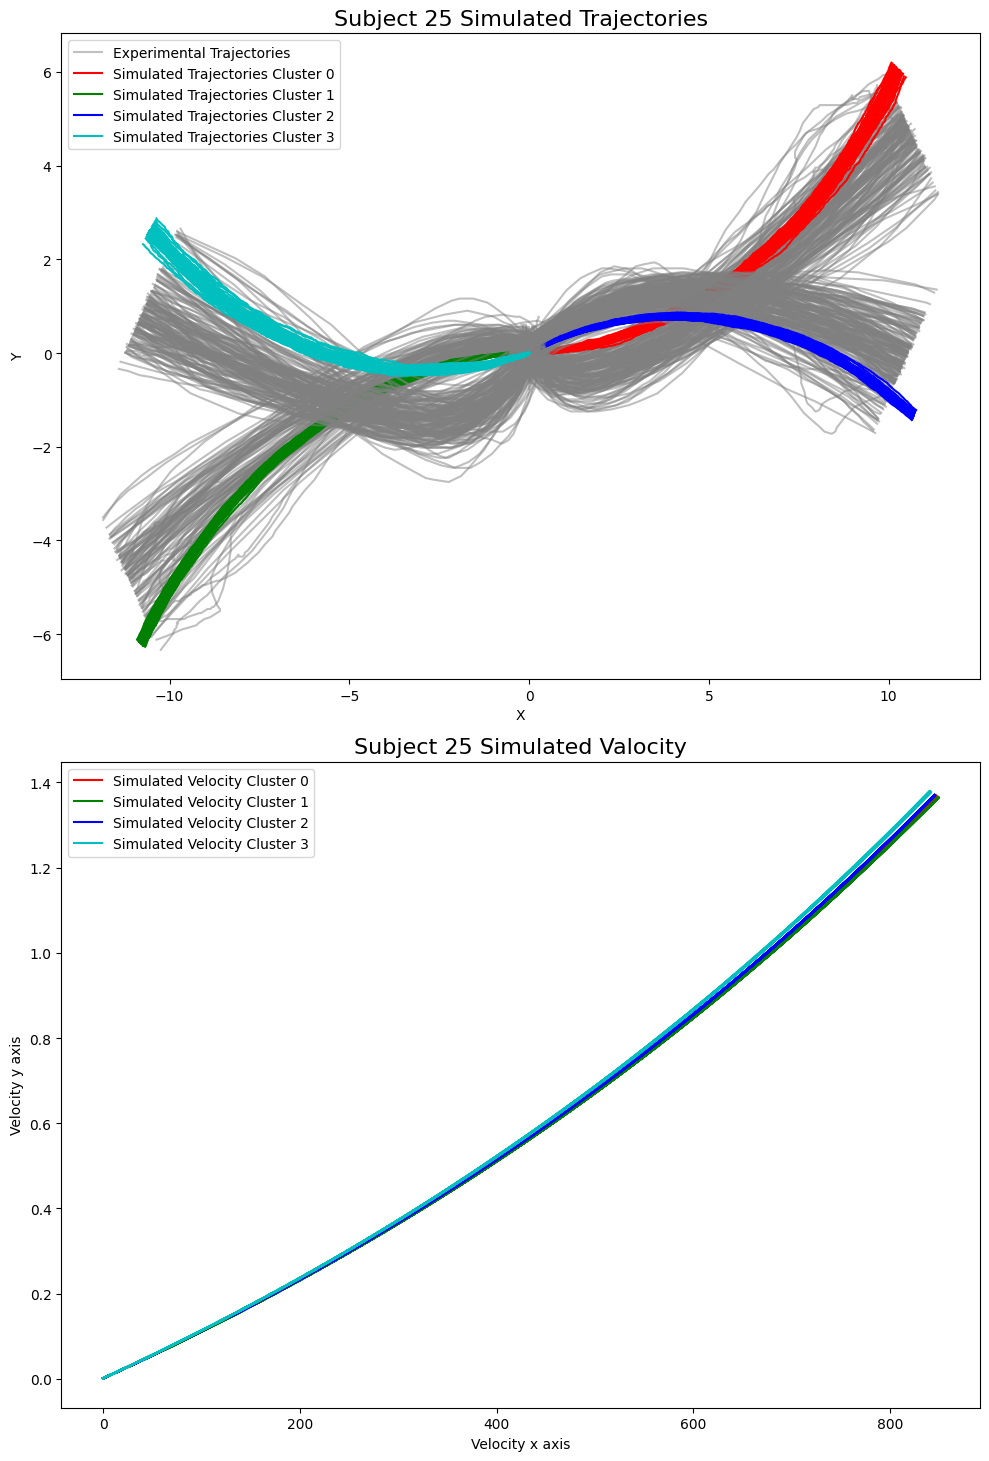

In [75]:
metrics_df = plot_multiple_trajectories_combined_(dfx, dfy, 
                           n_clusters = 4, new_params = params_fitted[:, :-1], 
                           opt_Sigma = params_fitted[:,-1], 
                           results = results,
                           n = 50,  
                           pic_name = 'Trajectories_simulated_25_inverted_combined_vel', pic_folder = 'project_plots',
                           saving_plot = True, inverse = True, metrics = True, plotting_vel= True)

In [76]:
metrics_df

0   
0             (19.30219817157421, 6.739797263071322)  \
1            (4.393426700375711, 2.5961119511822526)   
2             (3.20457041642777, 2.0259617769346128)   
3             (3.20457041642777, 2.0259617769346128)   
4  [1.694, 1.692, 1.692, 1.692, 1.694, 1.692, 1.6...   

                                                   1   
0           (30.687005821604288, 2.9499613649425718)  \
1           (5.5395853474429195, 1.7175451565948918)   
2            (4.394149819855822, 1.2058619459263609)   
3            (4.394149819855822, 1.2058619459263609)   
4  [1.698, 1.696, 1.698, 1.698, 1.696, 1.698, 1.6...   

                                                   2   
0           (18.358526696131733, 1.3383299312819847)  \
1            (4.284685133837927, 1.1568621055605481)   
2            (3.045025485095548, 1.0925088993969505)   
3            (3.045025485095548, 1.0925088993969505)   
4  [1.69, 1.69, 1.69, 1.69, 1.69, 1.69, 1.69, 1.6...   

                                                   3  
0           (27.119372825172675, 1.2999768961262512)  
1           (5.2076264099081335, 1.1401652933352475)  
2            (4.090885513862892, 0.9222787681388323)  
3            (4.090885513862892, 0.9222787681388323)  
4  [1.682, 1.68, 1.68, 1.68, 1.68, 1.68, 1.682, 1...

In [68]:
def compute_means_single_df(df):
    means_list = []
    for j in range(df.shape[1]):
        x_mean = 0
        y_mean = 0
        for i in range(df.shape[0]): 
            x_mean += df[i][j][0]
            y_mean += df[i][j][1]
        x_mean = x_mean / 4
        y_mean = y_mean / 4
        means_list.append((x_mean, y_mean))
        
    return means_list
# Compute the means for the single dataframe
means_list = compute_means_single_df(metrics_df)

# Print the result
print(f"Means for the dataframe: {means_list}")

Means for the dataframe: [(23.800621293297464, 3.1164124020177244), (4.849020952217838, 1.6617710220764599), (140.72836549273637, 48.36380944806603), (3.6791834278985087, 1.3198980703648793)]


### Sensitivity analysis

#### Parameter gamma

In [8]:
params_fitted

array([[ 2.95749222,  3.05271805, -3.21789397,  0.34131292],
       [ 2.96624475,  3.0617932 , -3.22741432,  0.23606798],
       [ 2.95038819,  3.04836258, -3.21082698,  0.23662838],
       [ 2.93367308,  3.03112578, -3.18704439,  0.32927743]])

In [90]:
col = 1
# Calculate the mean of the parameter distribution
mean_first_col = np.mean(params_fitted[:, col])
stdv = 2
#stdv = mean_first_col/2
print(mean_first_col, stdv)
# Define a range of values for sensitivity analysis
param_values = np.linspace(mean_first_col - stdv, mean_first_col + stdv, 5)
print(param_values)

3.048499902894373 2
[1.0484999 2.0484999 3.0484999 4.0484999 5.0484999]


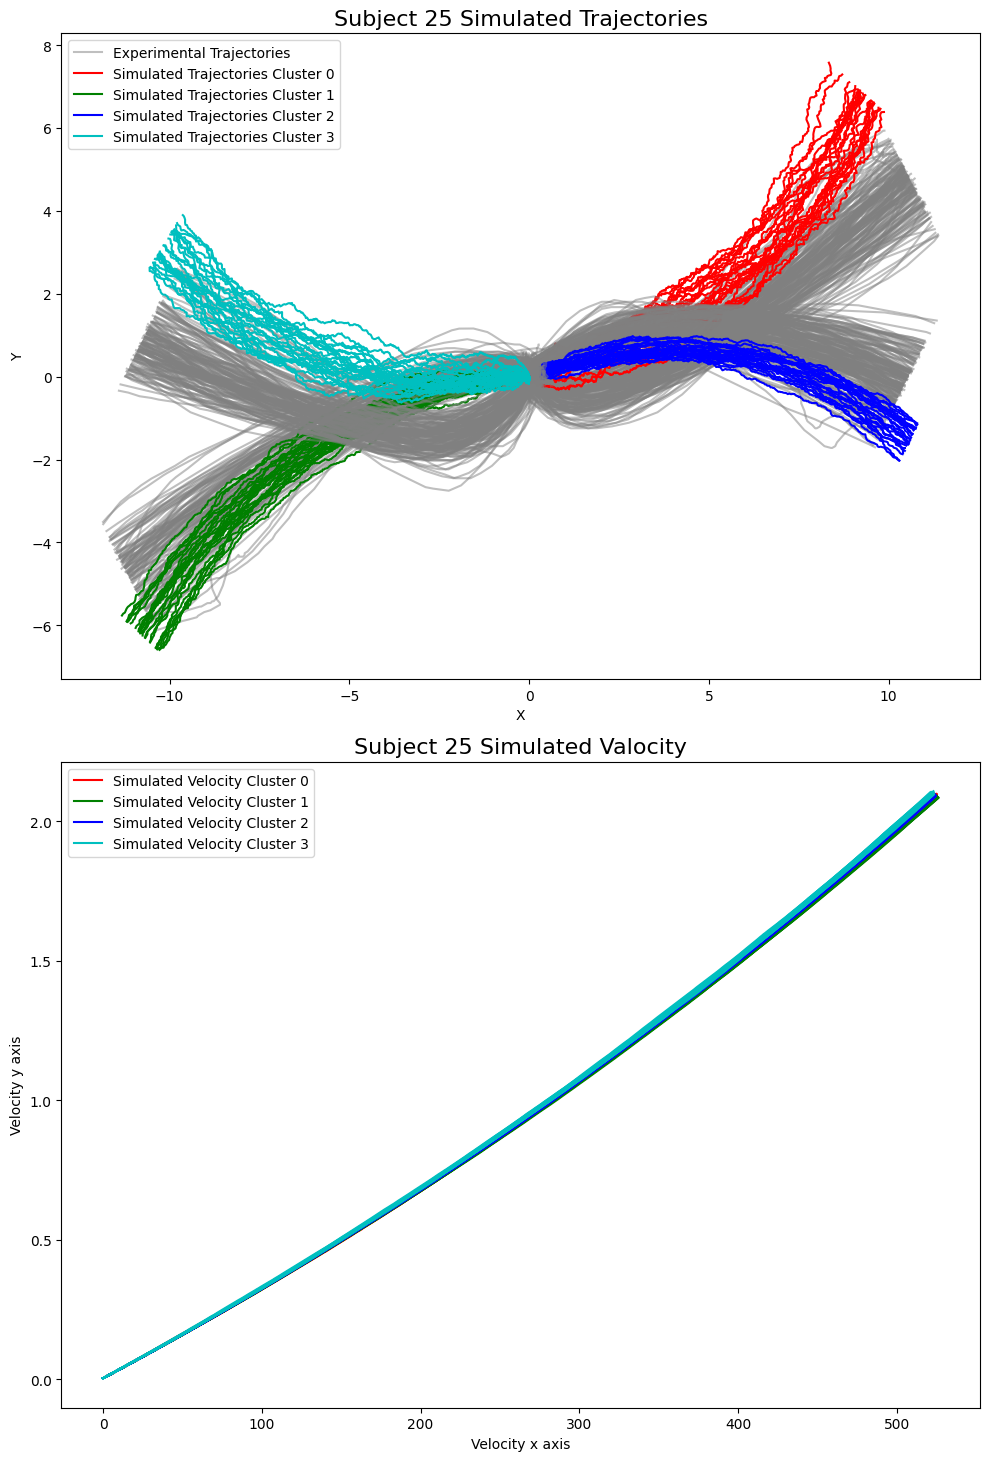

Metrics for first parameter value 1.0484999028943731:
                                                   0   
0             (17.48041721052012, 9.742712450516258)  \
1              (4.18095888649005, 3.121331839218038)   
2            (3.103305802046222, 2.5127591236560605)   
3            (3.103305802046222, 2.5127591236560605)   
4  [1.046, 1.046, 1.05, 1.048, 1.048, 1.046, 1.04...   

                                                   1   
0            (31.558424300597427, 3.183947964631444)  \
1            (5.617688519364297, 1.7843620609706552)   
2            (4.487585836969568, 1.2394889850180963)   
3            (4.487585836969568, 1.2394889850180963)   
4  [1.052, 1.048, 1.05, 1.05, 1.05, 1.052, 1.048,...   

                                                   2   
0             (18.9393196409455, 1.1478067692302587)  \
1            (4.351932862642242, 1.0713574423273768)   
2             (3.12993375306703, 1.0134982247373427)   
3             (3.12993375306703, 1.0134982247373

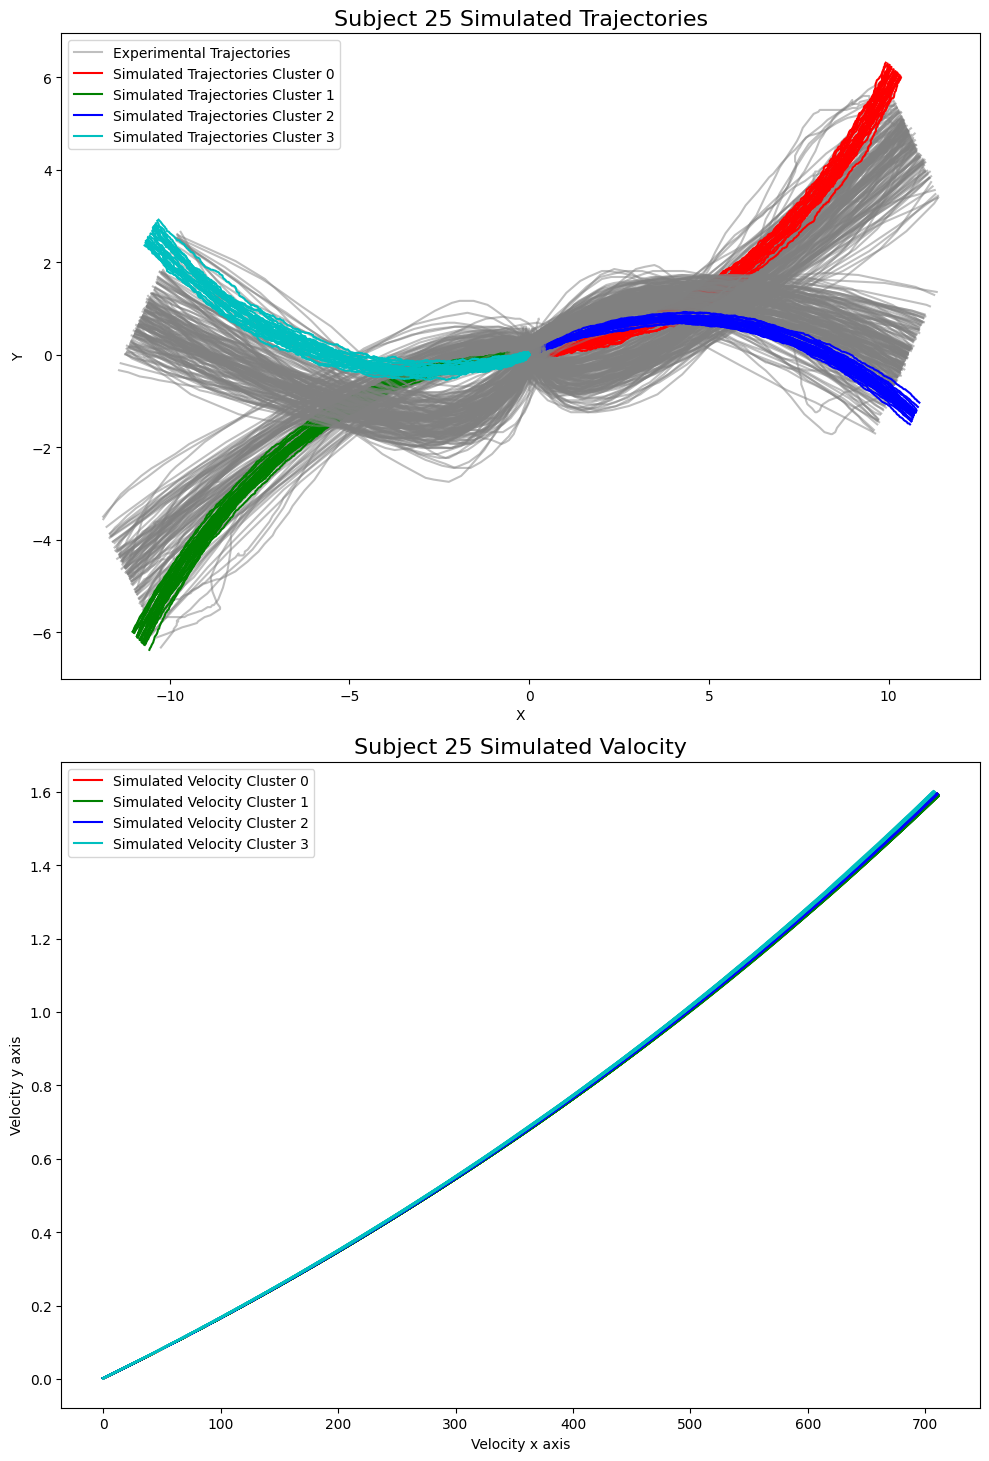

Metrics for first parameter value 2.048499902894373:
                                                   0   
0           (19.279027244048955, 7.1816777746210025)  \
1            (4.390788909074194, 2.6798652530716915)   
2           (3.2163149832093323, 2.1056359979152046)   
3           (3.2163149832093323, 2.1056359979152046)   
4  [1.42, 1.42, 1.42, 1.418, 1.42, 1.42, 1.42, 1....   

                                                   1   
0           (31.148086010868063, 2.9465343719955555)  \
1            (5.581047035357081, 1.7165472239340098)   
2            (4.438692704259362, 1.2073087659522956)   
3            (4.438692704259362, 1.2073087659522956)   
4  [1.422, 1.422, 1.422, 1.422, 1.422, 1.422, 1.4...   

                                                   2   
0           (18.760278286115746, 1.3315537157060662)  \
1            (4.331313690569611, 1.1539296840388786)   
2           (3.0889940653060894, 1.0895521004275732)   
3           (3.0889940653060894, 1.08955210042757

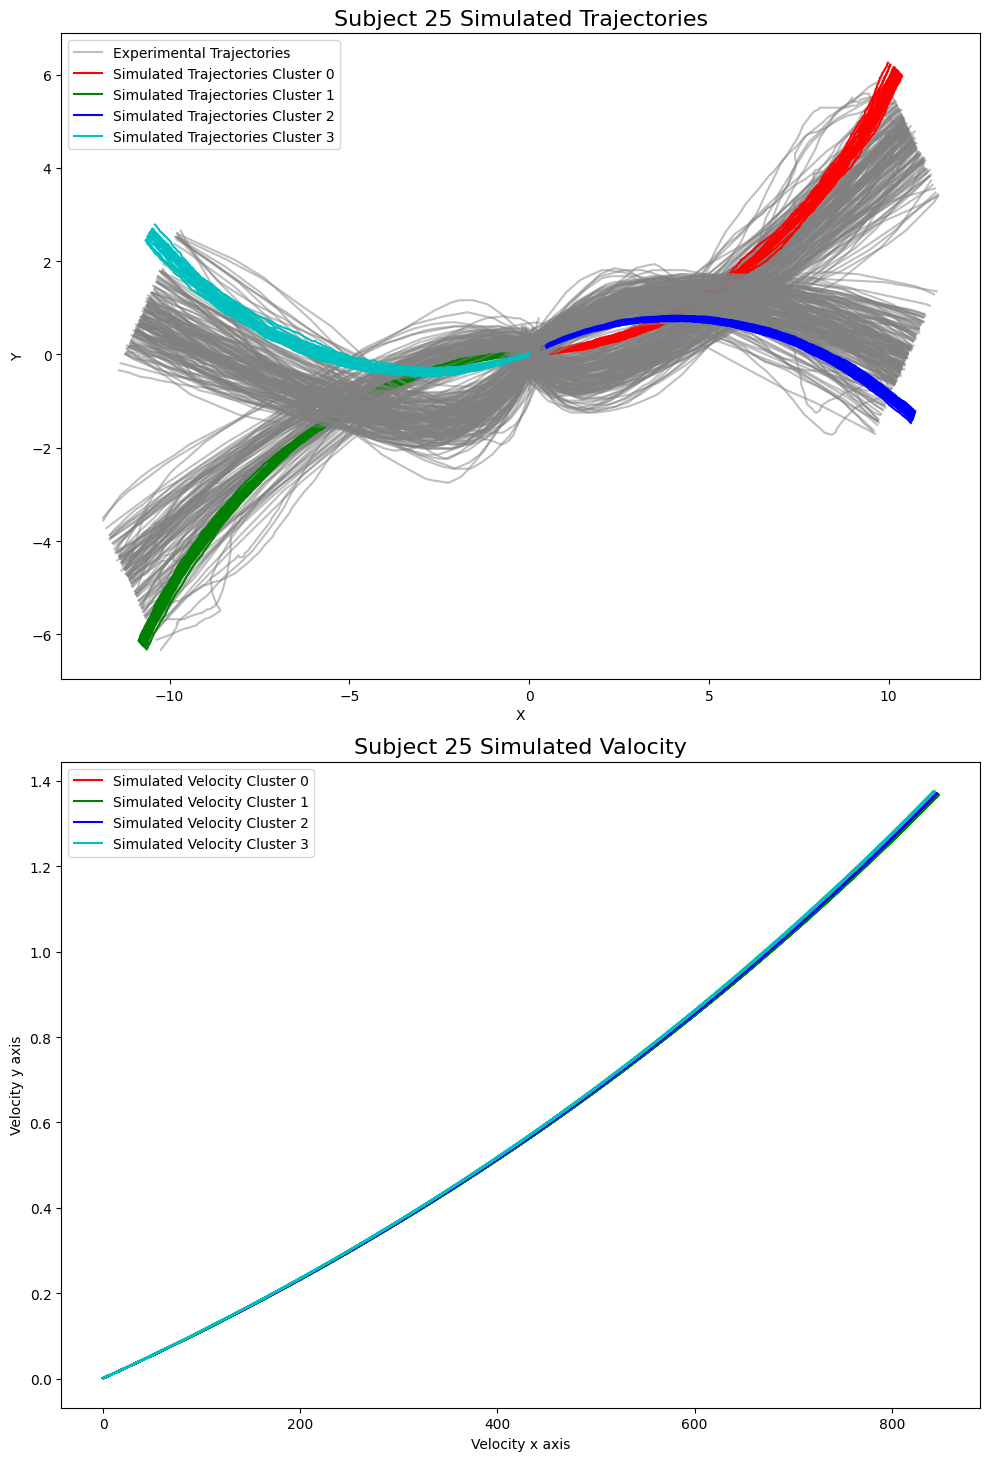

Metrics for first parameter value 3.048499902894373:
                                                   0   
0            (19.139597691146545, 6.853368049948681)  \
1            (4.374882591698496, 2.6178938194565267)   
2           (3.1919643577564423, 2.0493939909119527)   
3           (3.1919643577564423, 2.0493939909119527)   
4  [1.692, 1.692, 1.692, 1.692, 1.692, 1.692, 1.6...   

                                                   1   
0            (30.57006064055117, 2.9666410357565356)  \
1             (5.529019862557122, 1.722393983894665)   
2            (4.386829222098898, 1.2096649428747173)   
3            (4.386829222098898, 1.2096649428747173)   
4  [1.694, 1.694, 1.694, 1.694, 1.694, 1.694, 1.6...   

                                                   2   
0           (18.247549612654996, 1.3292463862340256)  \
1             (4.271715066885314, 1.152929480165212)   
2            (3.036111039045919, 1.0892008976642888)   
3            (3.036111039045919, 1.08920089766428

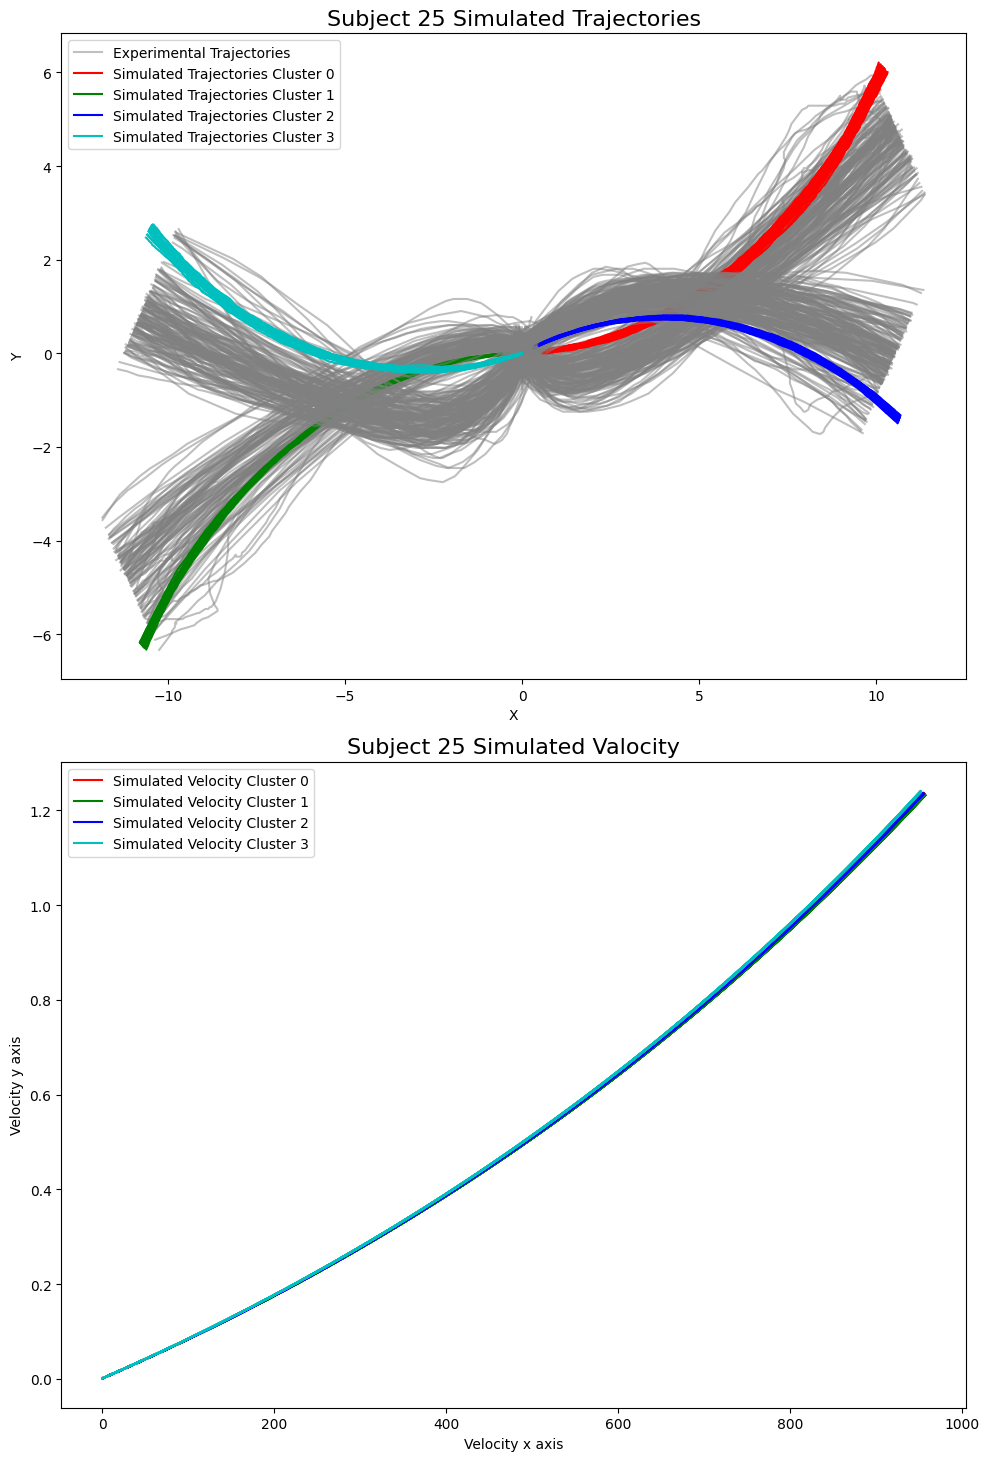

Metrics for first parameter value 4.048499902894373:
                                                   0   
0           (18.723142067736884, 6.6263533503009695)  \
1            (4.327024620652959, 2.5741704198247968)   
2            (3.151524532636646, 2.0094842281169725)   
3            (3.151524532636646, 2.0094842281169725)   
4  [1.9120000000000001, 1.9100000000000001, 1.912...   

                                                   1   
0            (30.20964608576856, 3.0306538544763004)  \
1            (5.496330238055985, 1.7408773232127244)   
2            (4.349824377444914, 1.2165348901740594)   
3            (4.349824377444914, 1.2165348901740594)   
4  [1.9140000000000001, 1.9140000000000001, 1.914...   

                                                   2   
0            (17.78958356530536, 1.3110835477737388)  \
1            (4.217769975390474, 1.1450255664279898)   
2            (2.993044350416486, 1.0825663410277837)   
3            (2.993044350416486, 1.08256634102778

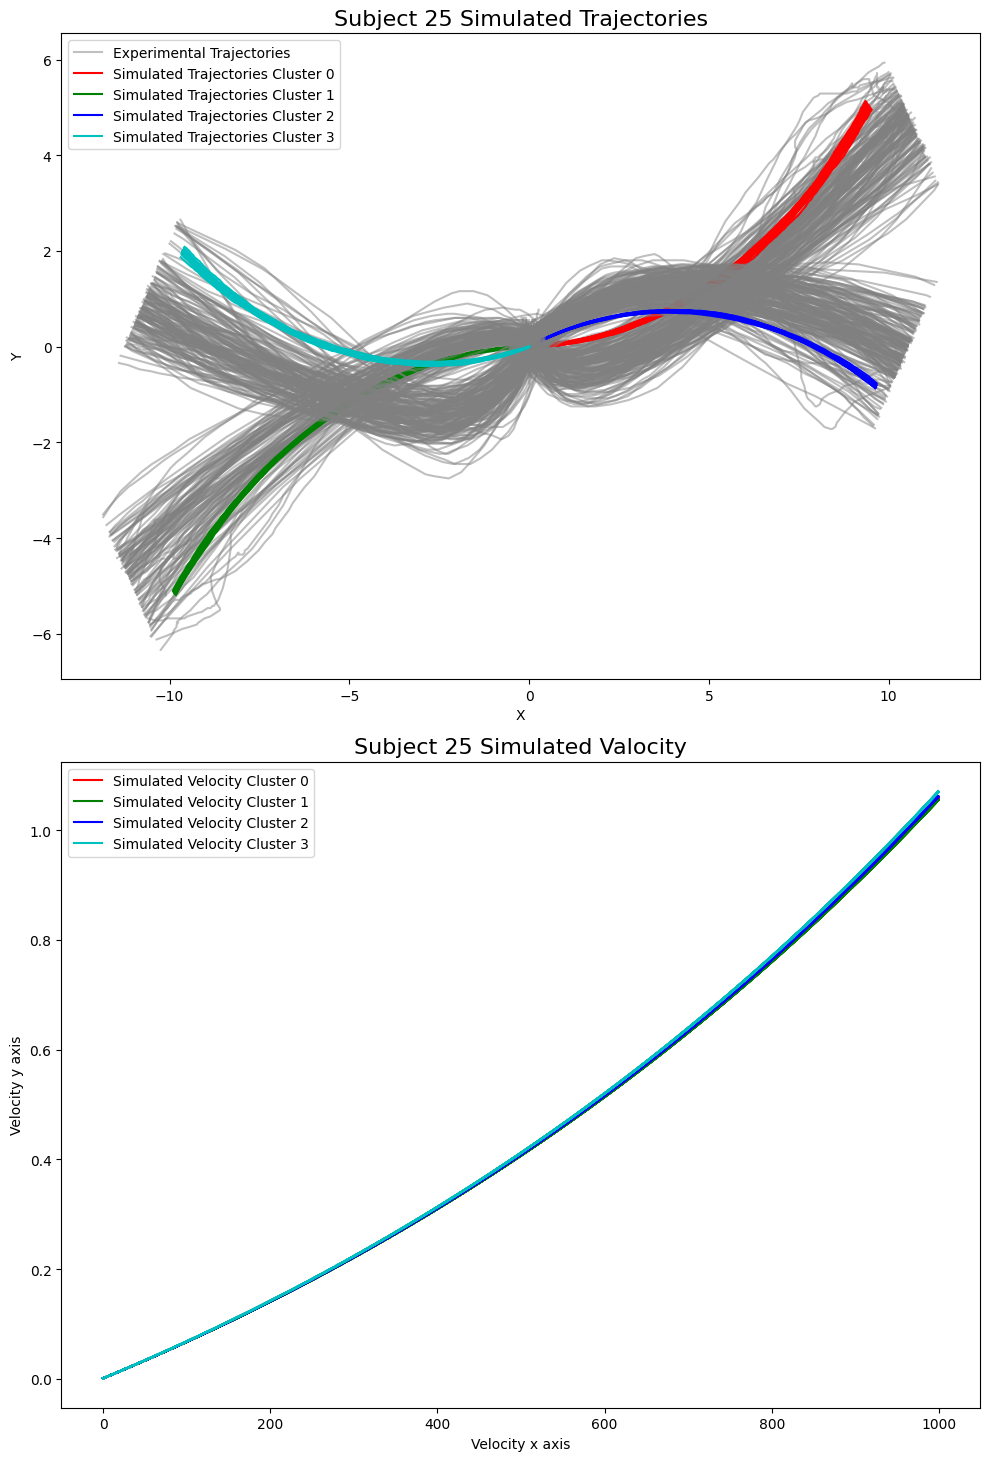

Metrics for first parameter value 5.048499902894373:
                                                   0   
0            (14.984456346594271, 4.842417676579194)  \
1            (3.8709761490603727, 2.200549403348899)   
2            (2.804200985324834, 1.7740775879603614)   
3            (2.804200985324834, 1.7740775879603614)   
4  [1.998, 1.998, 1.998, 1.998, 1.998, 1.998, 1.9...   

                                                   1   
0            (25.177230672906482, 2.003731054429841)  \
1            (5.017691767427179, 1.4155320746736333)   
2           (3.9721699628740588, 1.0369098016208382)   
3           (3.9721699628740588, 1.0369098016208382)   
4  [1.998, 1.998, 1.998, 1.998, 1.998, 1.998, 1.9...   

                                                   2   
0           (13.820313539677516, 1.3189608320300776)  \
1            (3.717568229323776, 1.1484602004554088)   
2           (2.6318724717328283, 1.0925312761627366)   
3           (2.6318724717328283, 1.09253127616273

In [92]:
metrics_dict = []
# Loop over the range of values and run the function for each
for value in param_values:
    new_params = params_fitted[:,:].copy()
    new_params[:, col] = value  # Change the first column to the current value in the loop
    
    # Run the function with the updated parameters
    metrics_df = plot_multiple_trajectories_combined_(
        dfx=dfx, dfy=dfy, 
        n_clusters=4, new_params=new_params[:, :-1], 
        opt_Sigma=new_params[:,-1], 
        results=results,
        n=25,  
        pic_name=f'Trajectories_simulated_25_SA_vel_eps{value}', 
        pic_folder='project_plots',
        saving_plot=True, 
        inverse=True, 
        metrics=True, 
        plotting_vel = True
    )
    metrics_dict.append(metrics_df)
    # Print or save the metrics_df for analysis
    print(f"Metrics for first parameter value {value}:")
    print(metrics_df)

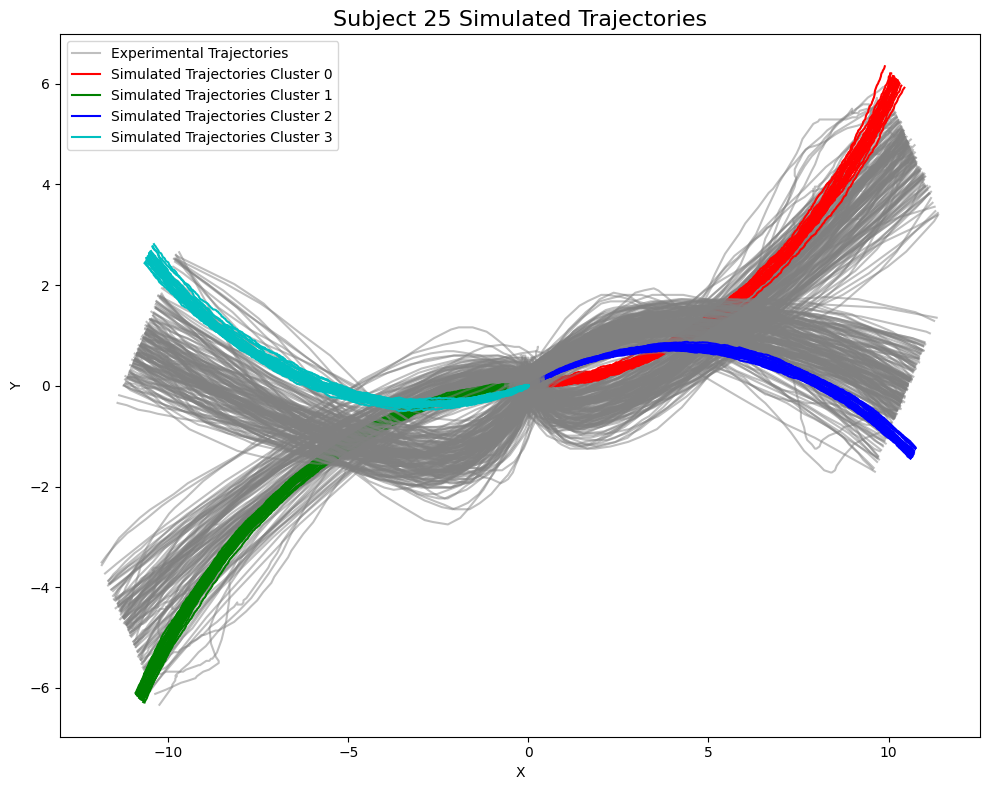

In [32]:
param_value = -5
metrics_df_ = evaluate_with_new_params(param_value)

In [33]:
print(metrics_df)
print(type(metrics_df))
print(metrics_df[3])
print(metrics_df[3][2])
print(metrics_df[3][2][1]) #[-1][-1][-1]

                                         0   
0  (19.217158152334758, 6.988506952748824)  \
1   (4.38373792012419, 2.6435784370335647)   
2  (3.2045323566168897, 2.063600426198221)   

                                          1   
0  (30.683291289019262, 3.0074402255292925)  \
1   (5.539250065579208, 1.7341972856423493)   
2   (4.400309613926006, 1.2182652256139352)   

                                         2   
0  (18.41949179178152, 1.3043245533646295)  \
1  (4.291793540209212, 1.1420702926548039)   
2  (3.054787810943266, 1.0788949311023341)   

                                          3  
0    (27.27711318105605, 1.303045192860599)  
1   (5.222749580542422, 1.1415100493909807)  
2  (4.1074512603247495, 0.9276302184671399)  
<class 'pandas.core.frame.DataFrame'>
0      (27.27711318105605, 1.303045192860599)
1     (5.222749580542422, 1.1415100493909807)
2    (4.1074512603247495, 0.9276302184671399)
Name: 3, dtype: object
(4.1074512603247495, 0.9276302184671399)
0.927630218467139

In [51]:
# Function to evaluate with new parameters
def evaluate_with_new_params(first_param):
    new_params = params_fitted[:,:].copy()
    new_params[:, col] = first_param  # Change the first column to the current value in the loop
    
    # Run the function with the updated parameters
    metrics_df = plot_multiple_trajectories_combined(
        dfx=dfx, dfy=dfy, 
        n_clusters=4, new_params=new_params[:, :-1], 
        opt_Sigma=new_params[:,-1], 
        results=results,
        n=25,  
        pic_name=f'Trajectories_simulated_25_SA_alpha{first_param}', 
        pic_folder='project_plots',
        saving_plot=True, 
        inverse=True, 
        metrics=True
    )
    metrics_dict.append(metrics_df)
    # Print or save the metrics_df for analysis
    #print(f"Metrics for first parameter value {value}:")
    #print(metrics_df)
    return metrics_df[0][0][1]
#metrics_df[3][3][1]


#### Sensitivity analyzer python

  0%|          | 0/5 [00:00<?, ?it/s]

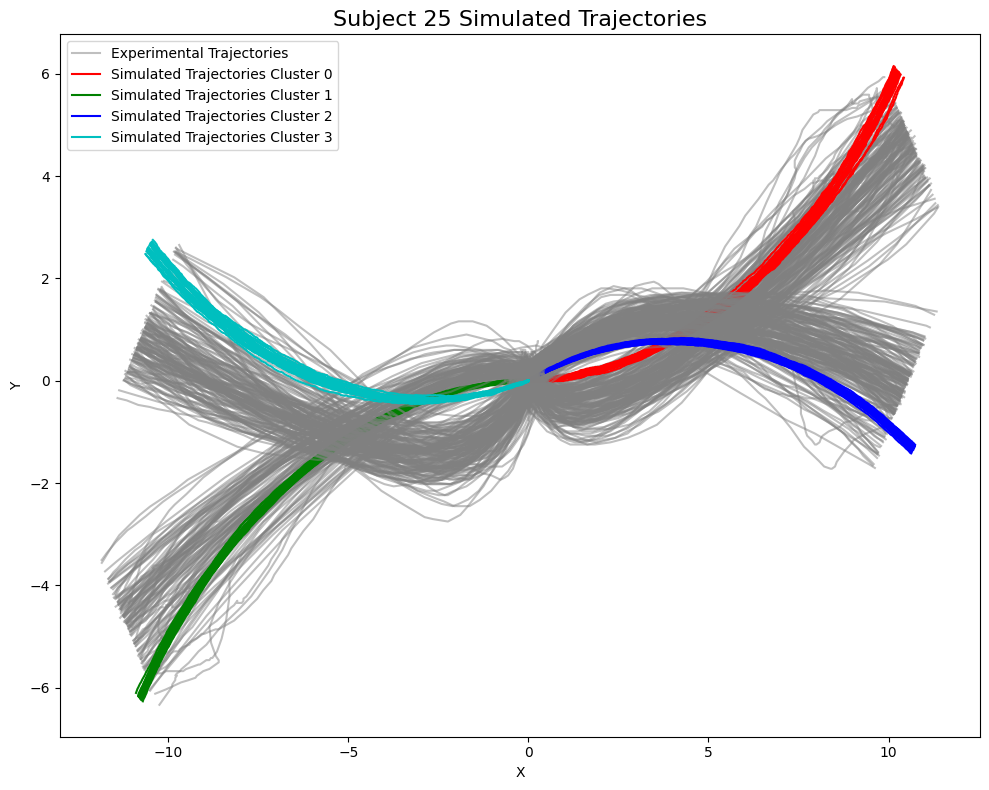

 20%|██        | 1/5 [00:12<00:49, 12.36s/it]

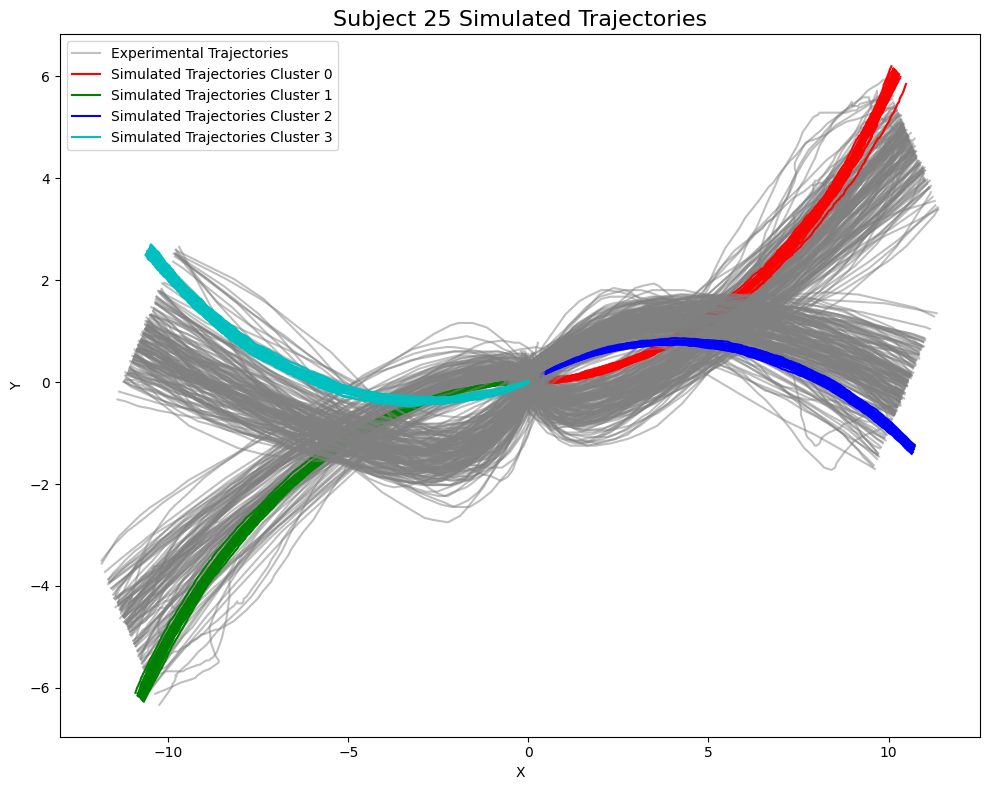

 40%|████      | 2/5 [00:28<00:42, 14.33s/it]

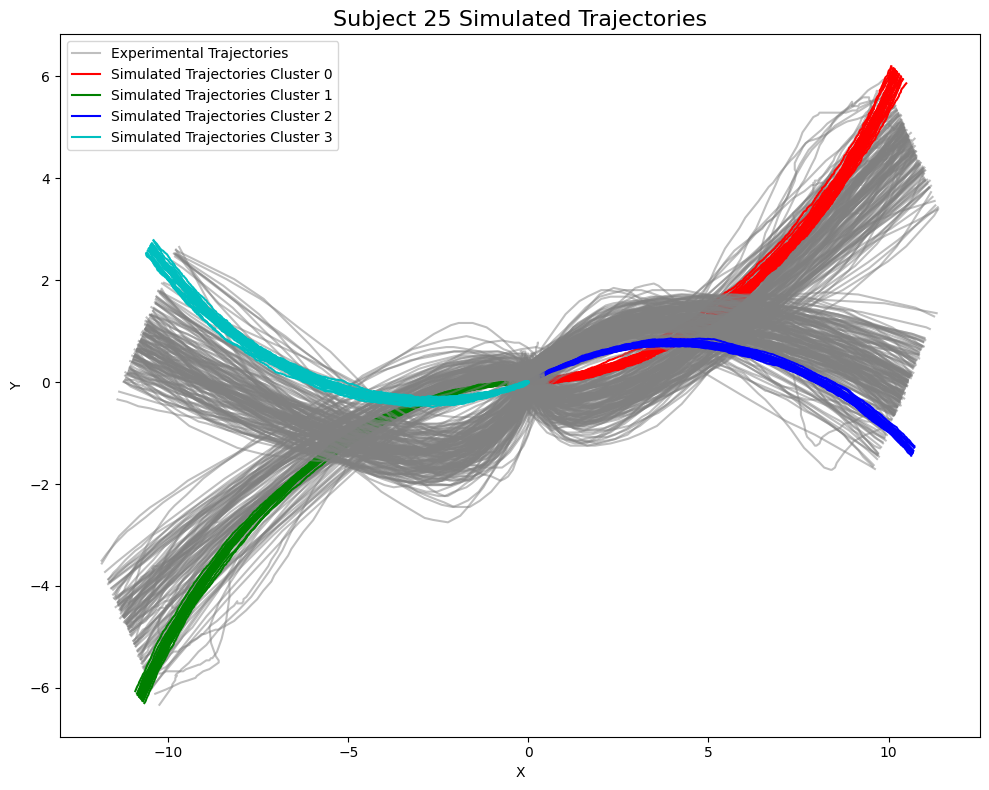

 60%|██████    | 3/5 [00:40<00:27, 13.66s/it]

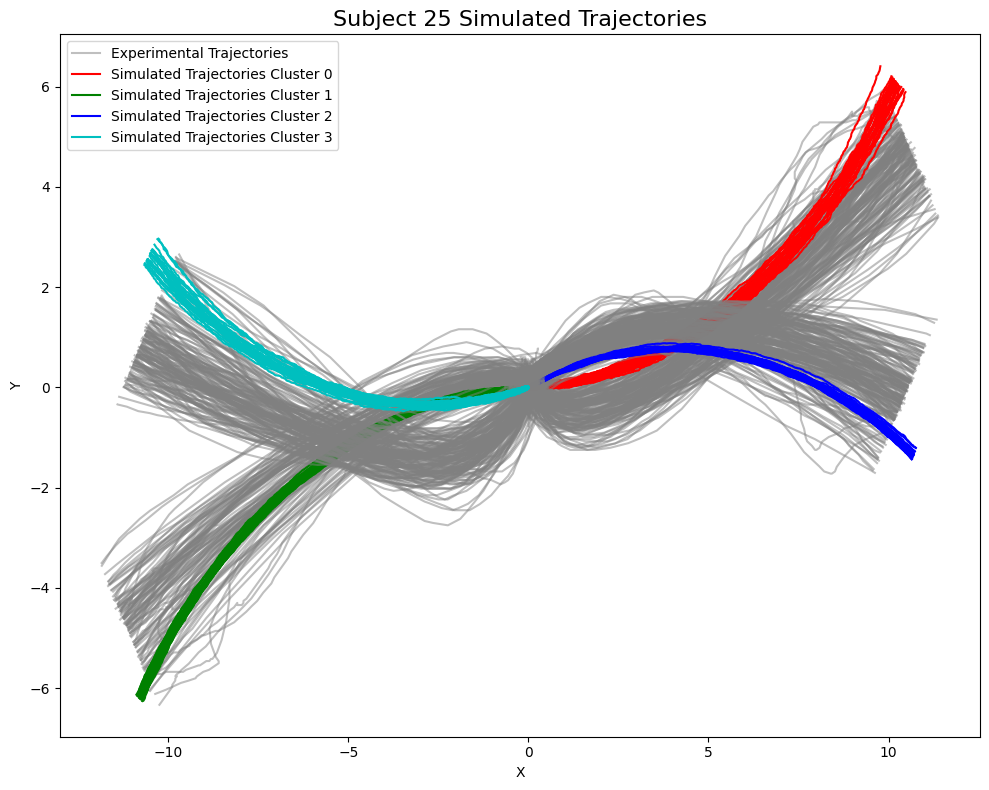

 80%|████████  | 4/5 [00:50<00:12, 12.06s/it]

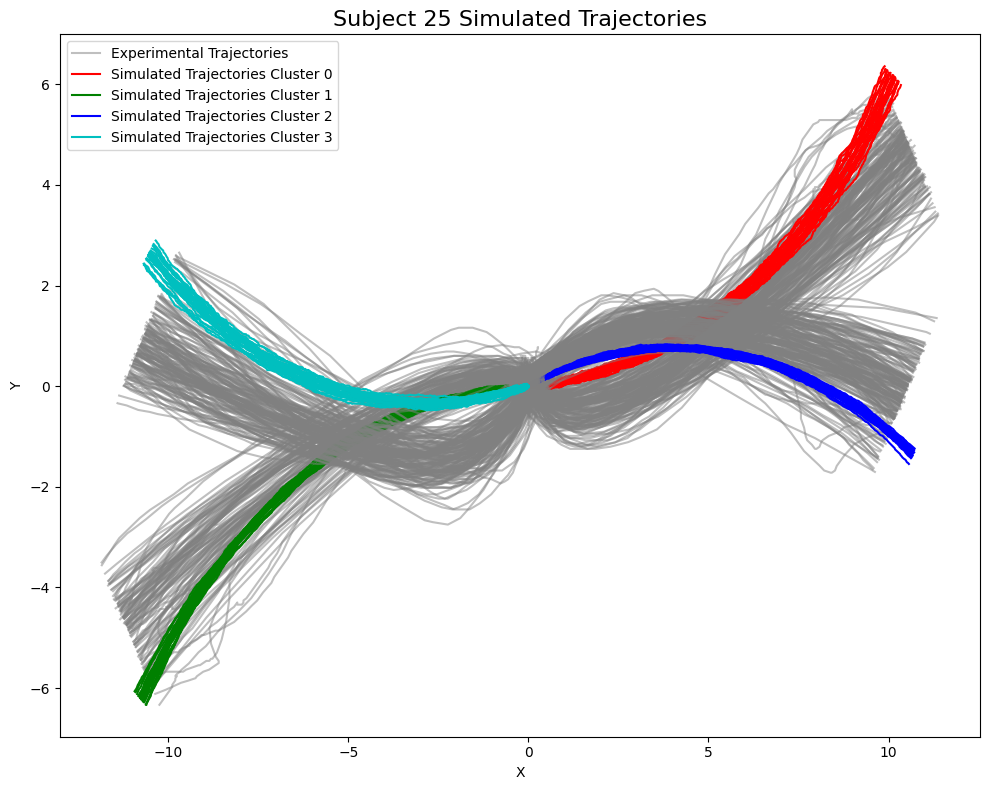

100%|██████████| 5/5 [01:01<00:00, 12.26s/it]


In [52]:
from sensitivity import SensitivityAnalyzer

sensitivity_values = {'first_param': param_values}

# Create SensitivityAnalyzer instance
analyzer = SensitivityAnalyzer(sensitivity_values=sensitivity_values,
    func=evaluate_with_new_params)


   first_param    Result
0    -3.710795  6.913225
1    -3.460795  6.827374
2    -3.210795  6.879804
3    -2.960795  6.968162
4    -2.710795  6.884759


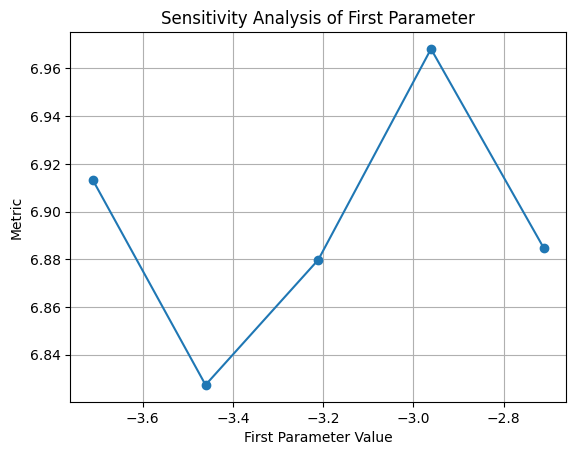

In [50]:
print(analyzer.df)

# Custom Plotting
plt.plot(analyzer.df['first_param'], analyzer.df['Result'], marker='o')
plt.xlabel('First Parameter Value')
plt.ylabel('Metric')
plt.title('Sensitivity Analysis of First Parameter')
plt.grid(True)
plt.show()

In [ ]:
metrics_df = plot_multiple_trajectories_combined_(dfx, dfy, 
                           n_clusters = 4, new_params = params_fitted[:, :-1], 
                           opt_Sigma = params_fitted[:,-1], 
                           results = results,
                           n = 50,  
                           pic_name = 'Trajectories_simulated_25_inverted_combined_acc', pic_folder = 'project_plots',
                           saving_plot = True, inverse = True, metrics = True)

### Parameter study: 

$\gamma (s^{-1})$
T-test results:  Ttest_indResult(statistic=0.6884099721898217, pvalue=0.49376251873629773)
$\gamma (s^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9717651009559631, pvalue=0.852381706237793)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
T-test results:  Ttest_indResult(statistic=0.7063600396237174, pvalue=0.4826103633803026)
$\varepsilon (m^{-1} kg^{-2} s^{4})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9575011730194092, pvalue=0.7631832957267761)
$\alpha (kg^{-1})$
T-test results:  Ttest_indResult(statistic=1.8144583554061242, pvalue=0.0744457395919127)
$\alpha (kg^{-1})$
Shapiro-Wilk test results: ShapiroResult(statistic=0.9390298128128052, pvalue=0.6484196782112122)
$\sigma$
T-test results:  Ttest_indResult(statistic=0.9738859373165252, pvalue=0.3338976399475704)
$\sigma$
Shapiro-Wilk test results: ShapiroResult(statistic=0.7805522680282593, pvalue=0.0716724768280983)


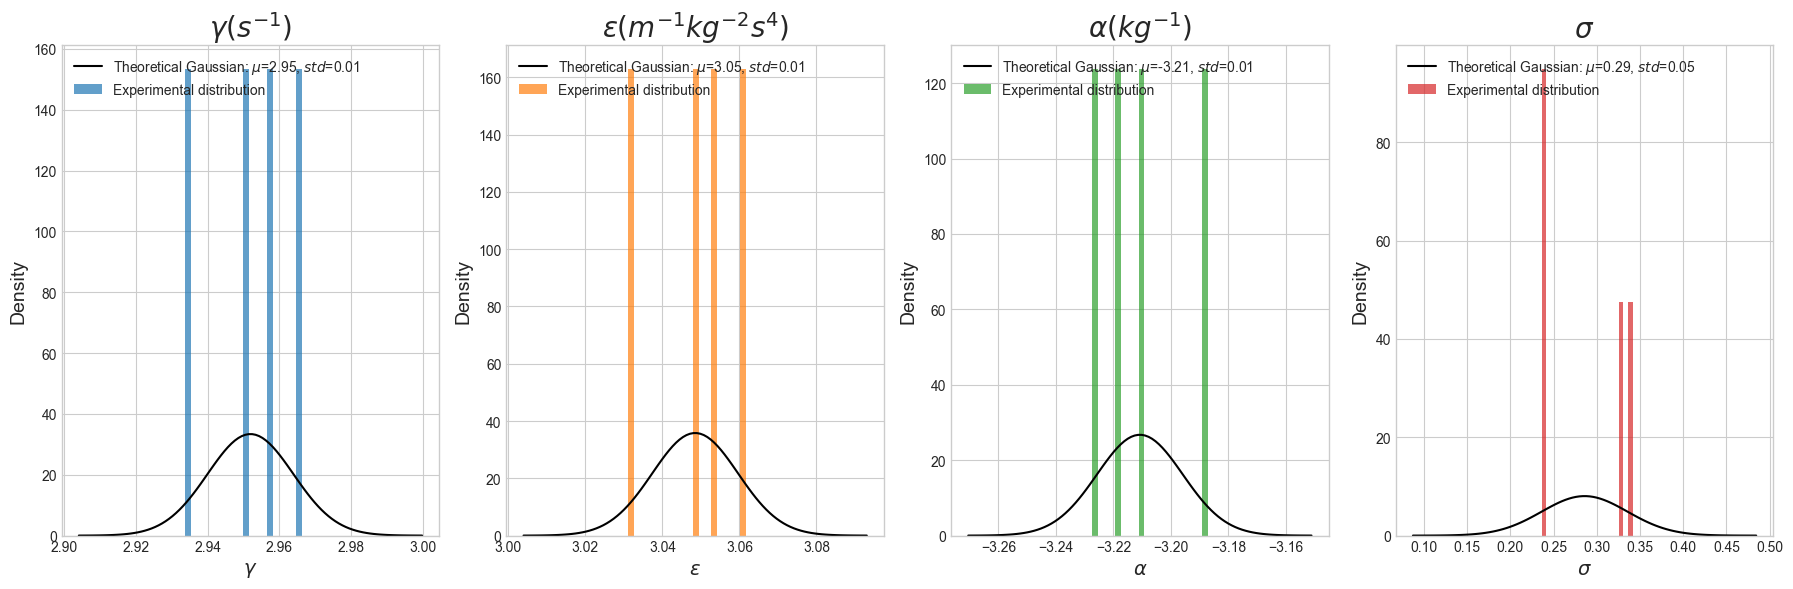

([Ttest_indResult(statistic=0.6884099721898217, pvalue=0.49376251873629773),
  Ttest_indResult(statistic=0.7063600396237174, pvalue=0.4826103633803026),
  Ttest_indResult(statistic=1.8144583554061242, pvalue=0.0744457395919127),
  Ttest_indResult(statistic=0.9738859373165252, pvalue=0.3338976399475704)],
 [ShapiroResult(statistic=0.9717651009559631, pvalue=0.852381706237793),
  ShapiroResult(statistic=0.9575011730194092, pvalue=0.7631832957267761),
  ShapiroResult(statistic=0.9390298128128052, pvalue=0.6484196782112122),
  ShapiroResult(statistic=0.7805522680282593, pvalue=0.0716724768280983)])

In [9]:
plot_gaussian_distributions_theo(params_fitted, style_label ='seaborn-whitegrid', 
                                     saving_plot = True,    folder_name = 'fitted_pics', 
                                     pic_name = 'params_gaussian_subject1_2', 
                                     )

In [8]:
new_params[cluster]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.0803674835926733
        x: [ 2.934e+00  3.031e+00 -3.187e+00]
      nit: 17
      jac: [-4.168e-01 -1.244e+00  9.032e-01]
 hess_inv: [[ 3.091e-01  2.927e-01 -3.977e-01]
            [ 2.927e-01  3.122e-01 -3.899e-01]
            [-3.977e-01 -3.899e-01  5.618e-01]]
     nfev: 304
     njev: 74

In [19]:
opt_sigma[cluster]

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 0.7530120481927711
       x: 0.3292774335412911
     nit: 41
    nfev: 46

# KALMAN FILTER STEP

In [93]:
def KalmanSimulation(in_con=(0,0,0,0), x_T=1., T=1., T_1=.2, sigma=1, alpha=.5, epsilon=.5, gamma=.5,
                    step=500, angle=math.pi*7/24, p=(.2,0), r=.1, Arc=True):
    
    x,v,y,w = in_con
    
    x_Story=[]
    v_Story=[]
    y_Story=[]
    w_Story=[]
    
    timestep=T/step
    l=x_T-x
    i=0
    Wt=0.
    
    ux, uy, lambda1, lambda3,l1,l3=res2.x
    
    Xp=np.array([x,v,ux,lambda1,y,w,uy,lambda3])
    Pp=np.zeros((8,8))
    
    Q=np.zeros((8,8))
    
    H=np.zeros(8)
    H[4]=1.
    
    M=np.zeros((8,8))
    for j in range(8):
        M[j][j]=1.

    for j in range(7):
        M[j][j+1]=timestep
    M[3][4]=0
    M[2][3]=l/(1-gamma)*timestep
    M[6][7]=l/(gamma)*timestep
    
    while(i<=step):
        
        if(i>=step*T_1):
            Xp[3]=l1
            Xp[7]=l3
        
        Q[4][4]=timestep*alpha*sigma*ux**2
        
        omega=timestep*alpha*ux**2*sigma*np.random.normal(0.,np.sqrt(timestep),1)
        
        Xm=np.dot(M,Xp)
        Pm=np.dot(np.dot(M,Pp),M.T)+Q
        
        K=np.dot(Pm,H)/(np.dot(H,np.dot(Pm,H))+timestep*alpha*sigma*ux**2)
        Xp=Xm+K*(omega)
        #print(i,K[4], omega)
        Pp=np.dot(np.identity(8)-np.outer(K,H),Pm)        
        
        x,v,ux,lambda1,y,w,uy,lambda3=Xp
        
        #We record the story
        if(Arc):
            x_Story.append((1+y)*np.cos(angle*(x/x_T-1)))
            y_Story.append((1+y)*np.sin(angle*(x/x_T-1)))
        else:
            x_Story.append(x)
            y_Story.append(y)
        v_Story.append(v)
        w_Story.append(w)
        
        i=i+1
        
    return x_Story, v_Story ,y_Story, w_Story

In [94]:
x,v,y,w=KalmanSimulation()
plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=25)
plt.show()

NameError: name 'res2' is not defined

## Optimizing with parameter boundary limitations: 

In [10]:
import scipy
import matplotlib.pyplot as plt
from typing import Tuple

def plot_trajectory_(x, y, showing = True, via = True, plot_title = 'Simulated Trajectory'):
    '''
        Function that plots the given trajectory (x(t), y(t)). 
    ''' 
    plt.plot(x,y,color='blue', label=plot_title, alpha = 1)
    if via:
        angle=math.pi*7/24
        T_1=.2
        plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
    if showing: 
        plt.show()

def generate_trajectory_vel_(params=(.5, .1, .5), parameters=(3.7, -0.15679707, 0.97252444, 0.54660283, -6.75775885, -0.06253371),
                            sigma=0, timestep=1/500, plotting=True, T=1.3, vel=0.1, 
                            bounds = [(0.01, 10), (0.01, 1), (0.01, 1)]  # Bounds for gamma, epsilon, alpha
                            ) -> Tuple[np.ndarray, np.ndarray]:
    
    partial_compute_vel = lambda params: ComputeVel(params, vel=vel, T=T, sigma=sigma)
    
    result = scipy.optimize.minimize(partial_compute_vel, params, bounds=bounds, method='L-BFGS-B')
    
    gamma, epsilon, alpha = result.x
    x, y, v, w, ux, uy, T = numericalSimulation(
        x_0=(0,0,0,0), p_T=1.0, sigma=sigma, gamma=gamma, epsilon=epsilon, alpha=alpha,
        u_0=parameters[:2], l_0=parameters[2:], i_max=1000, dt=timestep,
        Autoregr=True, Arc=True, angle=np.pi*7/24, angle0=0, p=(.2,0), r=.1
    )
    
    if plotting:
        plot_trajectory_(x, y, showing=True)
        
    return x, y, result


Computing trajectory with optimized velocity for cluster:  0


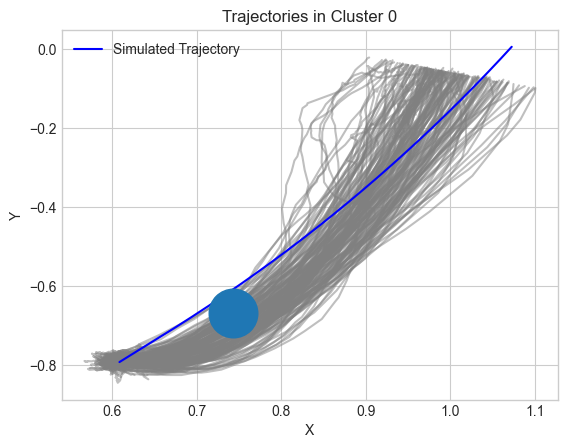

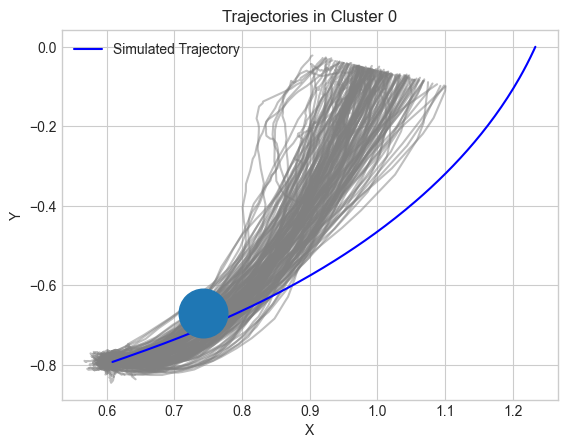

[10.         1.         0.0878486]
Computing trajectory with optimized velocity for cluster:  1


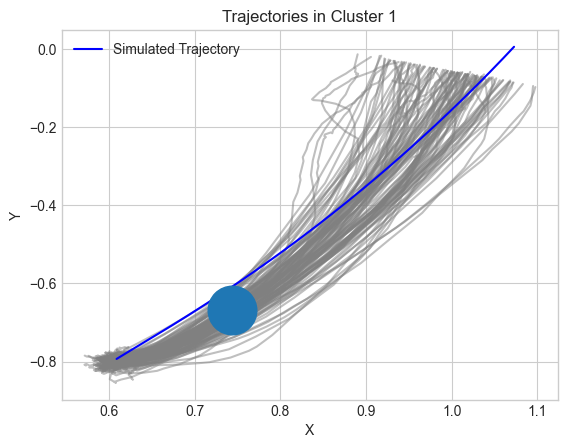

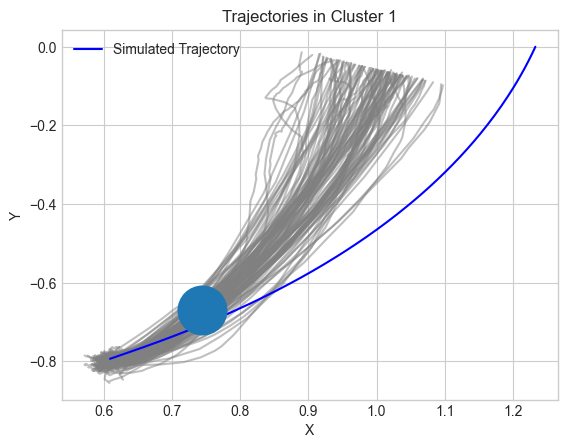

[10.          1.          0.08789306]
Computing trajectory with optimized velocity for cluster:  2


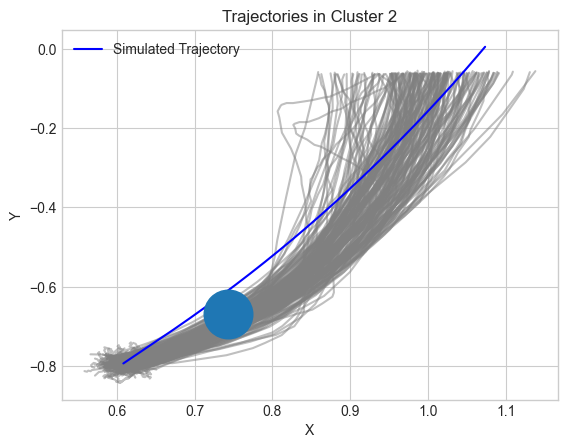

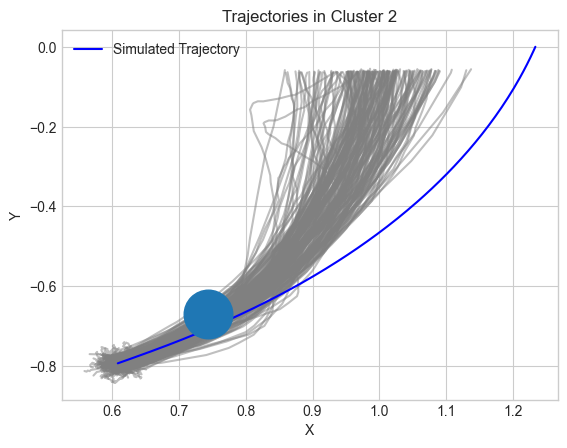

[10.         1.         0.0878494]
Computing trajectory with optimized velocity for cluster:  3


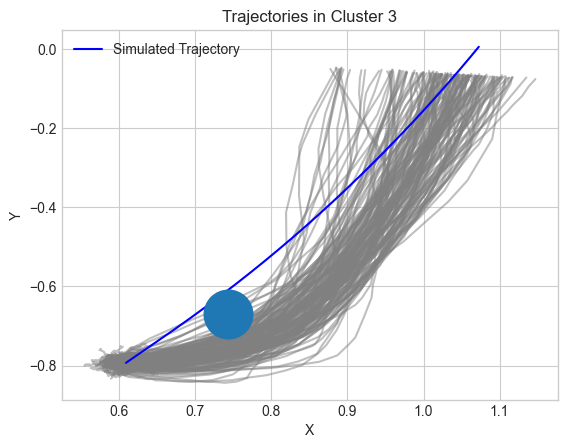

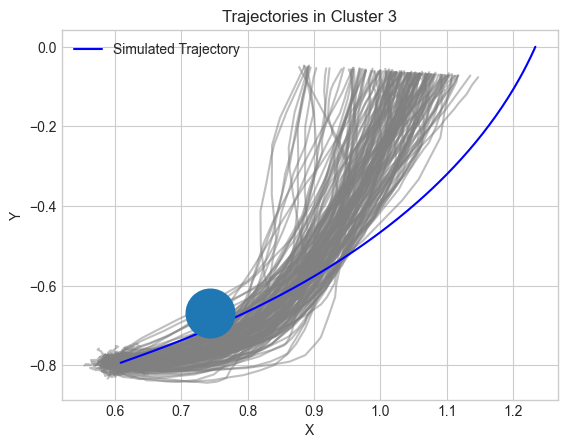

[10.          1.          0.08784861]


In [11]:
new_params_2 = [[] for _ in range(n_clusters)]
opt_sigma_2 = [[] for _ in range(n_clusters)]

for cluster in range(n_clusters):
    print('Computing trajectory with optimized velocity for cluster: ', cluster)
    
    ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
    x, y, T, params_0 = generate_trajectory(plotting = False)
    plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                    saving_plot = False)
    
    ## Generate the optimal trajectory with the time provided from optimizing the Functional 
    # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
    x_, y_, new_params_2[cluster] = generate_trajectory_vel_(plotting = False, 
                                 T = T,
                                 vel = results[results['cluster'] == cluster].max_vel.values[0])
    plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optVel', 
                    saving_plot = False)
    print(new_params_2[cluster].x)
    

In [12]:
new_params_2[cluster]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17.573956227849475
        x: [ 1.000e+01  1.000e+00  8.785e-02]
      nit: 12
      jac: [-9.278e-02 -3.517e+01  2.282e+00]
     nfev: 316
     njev: 79
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Computing trajectory with optimized velocity for cluster:  0


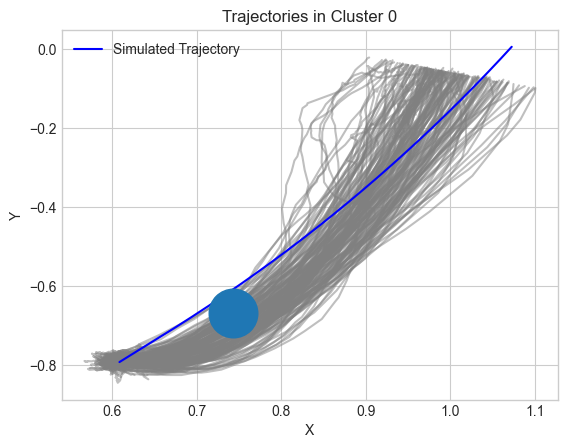

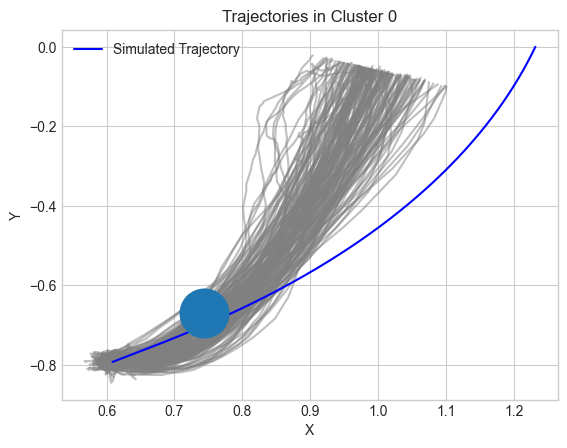

[ 6.26015198 10.          0.16754231]


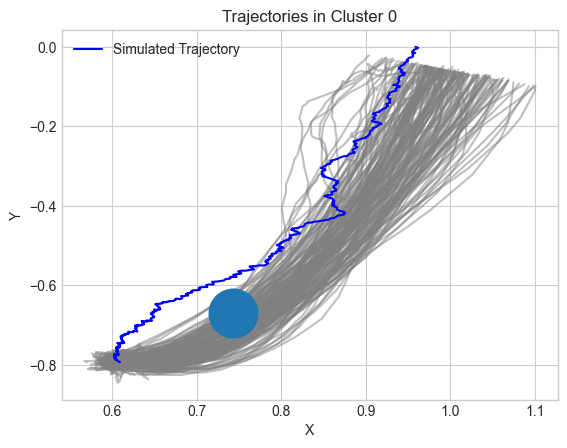

Parameters estimated:
[ 6.26015198 10.          0.16754231] 0.803852106778048
Computing trajectory with optimized velocity for cluster:  1


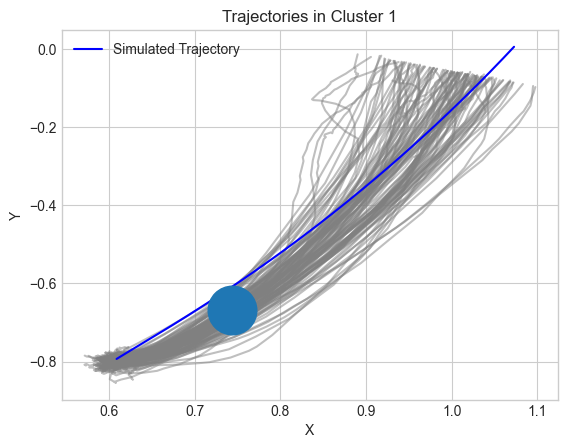

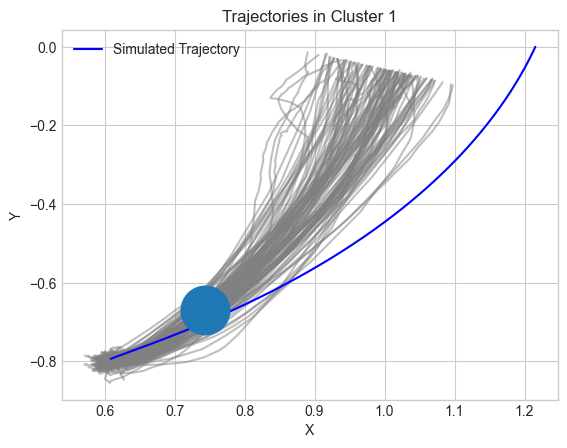

[5.79436659 5.61112639 0.15064788]


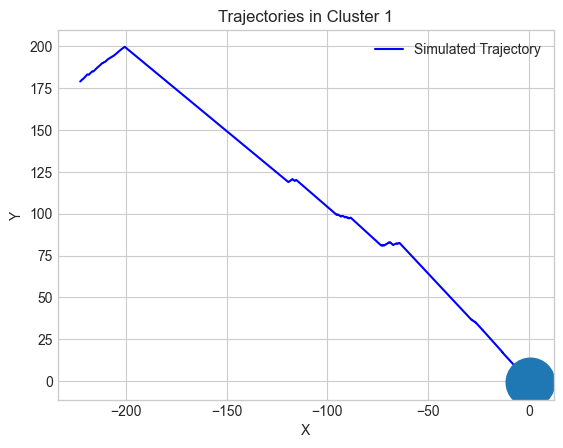

Parameters estimated:
[5.79436659 5.61112639 0.15064788] 7.798373971422981
Computing trajectory with optimized velocity for cluster:  2


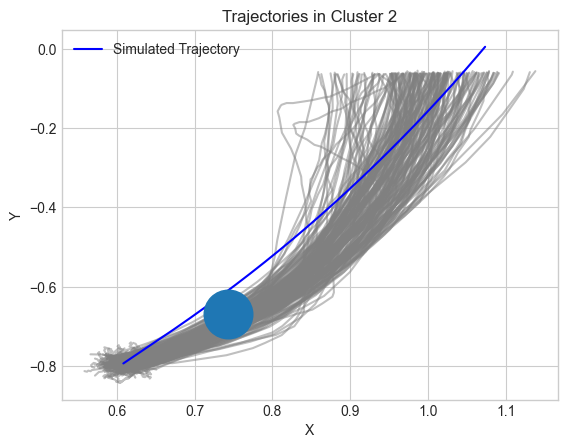

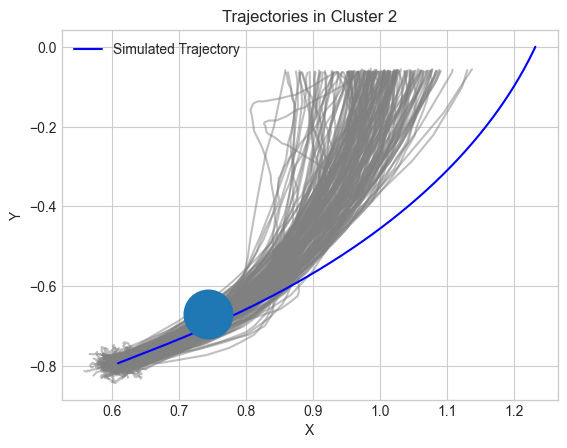

[ 6.26010523 10.          0.16752079]


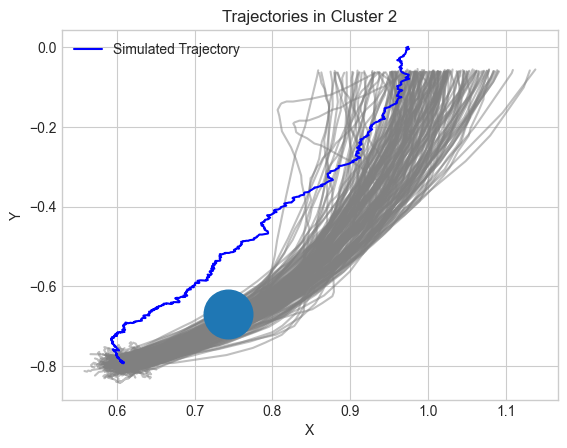

Parameters estimated:
[ 6.26010523 10.          0.16752079] 0.7981094484362812
Computing trajectory with optimized velocity for cluster:  3


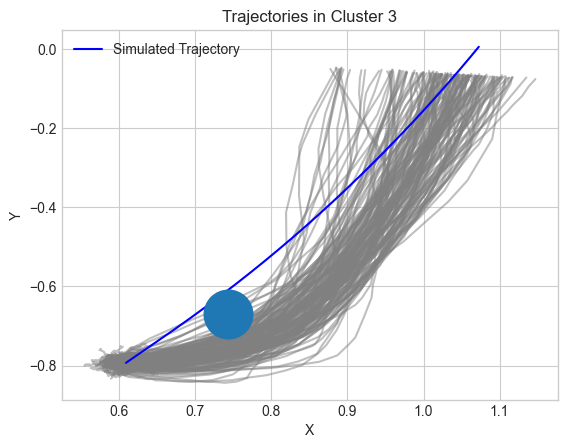

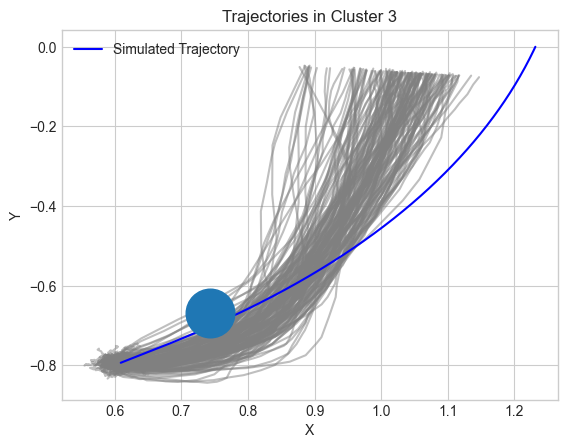

[ 6.26012077 10.          0.16752072]


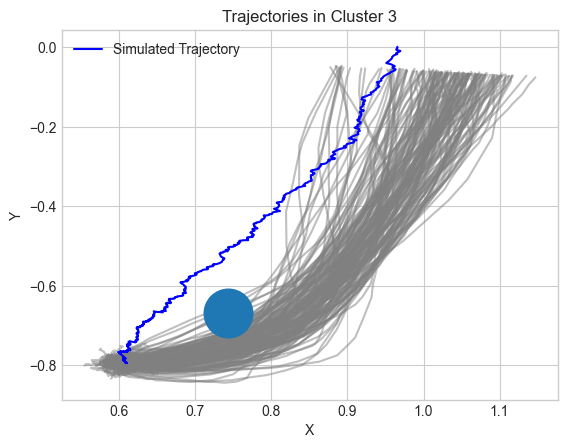

Parameters estimated:
[ 6.26012077 10.          0.16752072] 0.7847651549831289


In [14]:
for cluster in range(n_clusters):
    
    print('Computing trajectory with optimized velocity for cluster: ', cluster)
    
    ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
    x, y, T, params_0 = generate_trajectory(plotting = False)
    plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                    saving_plot = False)
    
    ## Generate the optimal trajectory with the time provided from optimizing the Functional 
    # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
    x_, y_, new_params_2[cluster] = generate_trajectory_vel_(plotting = False, 
                                 T = T,
                                 vel = results[results['cluster'] == cluster].max_vel.values[0], 
                                 bounds = [(0.001, 10), (0.001, 10), (0.001, 10)])
    plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optVel', 
                    saving_plot = False)
    print(new_params_2[cluster].x)
    idxr = results[results['cluster'] == cluster].idxrule.values[0]
    idxrule = np.fromstring(idxr[1: -1], dtype = int, sep = ', ')
    
    x__, y__, opt_sigma_2[cluster] = optimize_Sigma(dfx[cluster] , dfy[cluster],
                                        idxrule = idxrule, 
                                        new_params = new_params_2[cluster])
    if plotting: 
        plot_simulation(x__, y__, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optSigma', 
                    saving_plot = saving)
    
    print('Parameters estimated:')
    print(new_params_2[cluster].x, opt_sigma_2[cluster].x)

In [17]:
new_params_2[cluster]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.146789537325583
        x: [ 6.260e+00  1.000e+01  1.675e-01]
      nit: 15
      jac: [-9.717e-02 -4.787e-01  2.641e+00]
     nfev: 688
     njev: 172
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [18]:
opt_sigma_2[cluster]

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 0.1566265060240964
       x: 0.7847651549831289
     nit: 39
    nfev: 44